# Cratonic and Marginal Phanerozoic Sediment Coverage

Often, spatially coeval sedimentation is interpreted to record a eustatic rise, which we can test by identifying the spatial extent of sediments on Laurentia.

First we need to idenfity all units that contain marine sediments. I will consider all units that have at least one environment id corresponding to an interpreted marine environment of deposition for units that have multiple environmental ids.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import trange, tqdm
import geopandas as gpd
from shapely.geometry import Point
from helper import *
import glob
import os
import pickle

# processing
import scipy.signal as signal

# plotting styling
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Polygon

font = {'size': 8}
matplotlib.rc('font', **font)

# widgets
from ipywidgets import interact, Layout
import ipywidgets as widgets

## Some convenient values

Here are some useful values to define for the rest of this notebook.

In [2]:
# choose North American Lambert projection
epsg = 2252
proj4 = 'epsg:%d' % epsg

# wgs84
wgs84 = 'epsg:4326'

In [3]:
# time axis for analysis
nt = 60
t_edges = np.linspace(600, 0, nt+1)
dt = np.mean(np.diff(t_edges))
t = t_edges[0:-1]+dt/2

## Load and Process data

In order to make the subsequent analysis somewhat maleable, the following widgets permit the user to select what data to use and consider.

- I apply a couple modifications to the vanilla Macrostrat database in the [modify_macrostrat](modify_macrostrat.ipynb) notebook. The dropdown below permits the user to either load vanilla or the modified Macrostrat database.
- Macrostrat classifies sediments into 87 different environments, which are tabulated in `env` below. A selection interface below permits the user to restrict consideration of sediments by environment name, type, or class (as defined in the Macrostrat API).

Below are data and quantities used throughout the notebook.

In [4]:
# Macrostrat columns of North America
columns = load_shapefile('data/columns_2023-06.gpkg', 'col_id', project_id=1)

# list of unique environments
env = pd.read_csv('data/environments_2023-06.csv')

# outline of Laurentia
laurentia = gpd.read_file('gis/Laurentia/Laurentia_v2.shp')
laurentia = laurentia.to_crs(proj4)

# Macrostrat columns within Laurentian outline defined above
laurentia_columns = gpd.sjoin(columns, laurentia, predicate='intersects')

# cumulative area of all columns belonging to Laurentia
laurentia_area = laurentia_columns['col_area'].astype(float).sum()

# buffered and difference margin ring files
buffer_files = glob.glob('gis/Laurentia_buffered_margin_buffers/*.shp')
ring_files = glob.glob('gis/Laurentia_buffered_margin_rings/*.shp')

# sutures
sut = gpd.read_file('gis/sutures/sutures_NA.shp')
sut = sut.to_crs(proj4)

# political boundaries
bound = gpd.read_file('gis/political_boundaries/boundaries.shp')
bound = bound.to_crs(proj4)

The following perimeter of Laurentia is compiled from several data sources and is meant to represent the basic limits of the continental margin that might have been open to marine sedimentation over the Phanerozoic. The goal is to avoid incorporation of marine sediments that accumulated on pre-accretion Appalachian and Western forearcs, thereby only considering marine sedimentation that might record a eustatic signal as craton-ward transgressions.

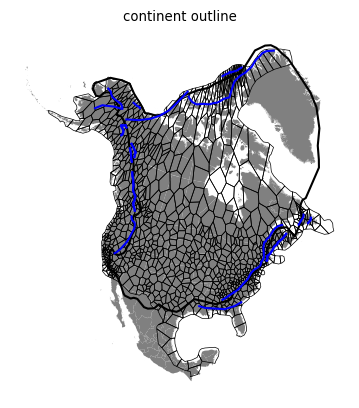

In [5]:
plt.figure()
ax = plt.axes()
columns.boundary.plot(color='k', ax=ax, linewidth=0.5)
laurentia.boundary.plot(color='k', ax=ax)
bound.plot(color='gray', ax=ax, linewidth=0.25)
sut.plot(color='b', ax=ax)
plt.title('continent outline')
ax.axis('off')
plt.show()

### Set up widgets for data loading

##### Loading widgets and functions

Choose which sediments to consider. Probably most parsimonious to just take those that are "marine".

In [6]:
style = {'description_width': 'initial'}

units_radio = widgets.RadioButtons(
                    options=['Vanilla Macrostrat', 'Modified Macrostrat'],
                    value='Modified Macrostrat',
                    description='Units to use: ')

env_key_toggle = widgets.SelectMultiple(options=env['key'].values,
                                        description='Environment Key',
                                        layout=Layout(height='5in', width='4in'),
                                        style=style)
env_type_toggle = widgets.SelectMultiple(options=env['type'].unique()[[isinstance(x, str) for x in env['type'].unique()]], 
                                         description='Environment Type',
                                         layout=Layout(height='2in'),
                                         style=style)
env_class_toggle = widgets.SelectMultiple(options=env['class'].unique(), 
                                          description='Environment Class',
                                          layout=Layout(height='1in'),
                                          style=style)

load_button = widgets.Button(description='Load Data')

load_output = widgets.Output()

In [7]:
"""
get environment codes corresponding to user-selected environment keys
"""
def select_envs(keys):
    env_ids = []
    for key in keys:
        env_ids.append(env.loc[env['key'] == key]['environ_id'].values[0])
    return env_ids

In [8]:
@load_output.capture()
def load_data(b):
    
    # if make sure at least one environment key is selected
    assert len(env_key_toggle.value) > 0, 'no environment keys have been selected!'
    
    # load the file
    global units_seds
    if units_radio.value == 'Vanilla Macrostrat':
        units_seds = gpd.read_file('data/units_seds_2023-06.gpkg')
        units_seds.set_index('unit_id', inplace=True)
        conf = 'Vanilla'
    elif units_radio.value == 'Modified Macrostrat':
        units_seds = pd.read_csv('data/units_seds_mod_no-pleis_2023-06.csv', index_col=0)
        conf = 'Modified'
        
    # add env codes
    units_seds['environ_ids'] = env_id(units_seds['environ_y'].values, env)
        
    # select the envs
    env_ids = select_envs(env_key_toggle.value)
    
    # filter units_seds to only include units with one match to env_ids
    idx = np.zeros(units_seds.shape[0]).astype(bool)
    for ii in trange(units_seds.shape[0], desc='Filtering units by requested environments'):
        # some units have nans for environ-ids, weirdly, so let's ignore those
        if type(units_seds.iloc[ii]['environ_ids']) == float and np.isnan(units_seds.iloc[ii]['environ_ids']):
            continue
        else:
            idx[ii] = len(set(env_ids).intersection(set(units_seds.iloc[ii]['environ_ids']))) > 0
            
    units_seds = units_seds[idx]
    
#     return units_seds

In [9]:
"""
when user selects environment type(s) with the widget, restrict the environment keys to only correspond to the chosen types, and deselect environment class
"""
def on_update_type(*args):
    cur_names = env_key_toggle.value
    
    new_names = ()
    for type_ in env_type_toggle.value:
        cur_env_names = tuple(env.loc[env['type'] == type_]['key'].values)
        new_names = new_names + cur_env_names
        
    env_class_toggle.value = []
        
    env_key_toggle.value = new_names

"""
when user selects environment class/classes with the widget, restrict the environment keys to only correspond to the chosen classes, and deselect environment type
"""
def on_update_class(*args):
    cur_names = env_key_toggle.value
    
    new_names = ()
    for class_ in env_class_toggle.value:
        cur_env_names = tuple(env.loc[env['class'] == class_]['key'].values)
        new_names = new_names + cur_env_names
    
    env_type_toggle.value = []
        
    env_key_toggle.value = new_names

In [10]:
# if user changes the types or classes, reflect that in the environment names that are selected
env_type_toggle.observe(on_update_type, 'value')
env_class_toggle.observe(on_update_class, 'value')

# gather all the loading widgets here
load_widgets = widgets.VBox([widgets.HBox([units_radio, env_key_toggle, env_type_toggle, env_class_toggle], layout=Layout(align_items='stretch', display='flex')),
                             load_button, 
                             load_output])

# save the output here
load_button.on_click(load_data)

#### Buffered sediment fraction processing widgets and functions

The following function computes the area fraction of sediment presence (based on the units selected by the user above) for each time window and within a progressively expanding area of Laurentia. The first section expands area progressively inward from the margin, while the second section expands areas progressively outwards from the craton interior. The following figure shows the area increments, which were computed as 100 km geodesic buffers progresively inland from the margin.

In [11]:
processing_button = widgets.Button(description='Process Buffered Sediment Area Fractions', layout=Layout(width='3in'))
processing_output = widgets.Output()

processing_widgets = widgets.VBox([processing_button, processing_output])

In [12]:
"""
this function computes the sediment coverage fraction in time windows in the buffer zones progressing both inwards and outwards with respect to the craton.
"""
@processing_output.capture()
def process_buffers(b):
    
    global n_rings
    global n_interiors
    global buffer_widths 
    
    n_interiors = len(buffer_files)
    n_rings = len(ring_files)
    buffer_widths = np.arange(n_interiors)*100 + 100
    ring_widths = np.arange(n_rings)*100 + 100
    
    # progressing outwards from craton interior
    global interiors
    global interior_columns
    global n_interior_cols 
    
    interiors = []
    interior_columns = []
    n_interior_cols = []

    for ii in trange(n_interiors, desc='Creating area slices buffered outwards from contintental interior.'):
        cur_interior = gpd.read_file(buffer_files[ii])
        cur_interior = cur_interior.to_crs(proj4)
        interiors.append(cur_interior)
        
        interior_columns.append(gpd.sjoin(columns, interiors[ii], predicate='intersects'))
    #     interior_columns.append(gpd.sjoin(interiors[ii], columns, op='intersects'))
        n_interior_cols.append(interior_columns[ii].shape[0])

    interiors.reverse()
    interior_columns.reverse()
    n_interior_cols.reverse()
    
    # list of rings for each buffer distance from the margin edge
    global rings
    global ring_columns
    global n_ring_cols
    
    rings = []
    ring_columns = []
    n_ring_cols = []

    # rings contracting inwards from the margin
    # computed as spatial difference between buffered polygon and laurentia polygon
    for ii in trange(n_rings, desc='Creating buffered rings inwards from margin.'):
        
        cur_ring = gpd.read_file(ring_files[ii])
        cur_ring = cur_ring.to_crs(proj4)
        
        # rings.append(gpd.overlay(laurentia, interiors[ii], how='difference'))
        rings.append(cur_ring)

        # indices of columns in margin zone
        ring_columns.append(gpd.sjoin(columns, rings[ii], predicate='intersects'))

        n_ring_cols.append(ring_columns[ii].shape[0])

    # proportion of columns progressing inwards from the margin containing sediments of selected environments within time windows
    global margin_sed_frac
    margin_sed_frac = np.zeros((nt, n_rings))
    for ii in trange(n_rings, desc='Computing area coverage of sediments inwards from margin.'):

        # isolate sed units from these columns
        units_seds_ring = units_seds[units_seds['col_id'].isin(ring_columns[ii].index)]

        for jj in trange(nt, leave=False):
            t1 = t_edges[jj]
            t2 = t_edges[jj+1]
            df = seds_by_column_and_age_range(units_seds_ring, columns.loc[ring_columns[ii].index], t1, t2, method='presence')
            # make into area fraction of current ring
    #         margin_sed_frac[jj, ii] = df['presence'].sum()/n_ring_cols[ii]
    #         margin_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/laurentia_area
            margin_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/ \
                                        columns.loc[ring_columns[ii].index]['col_area'].astype(float).sum()
    
    # now compute the sedimentation histories for each interior slice
    # proportion of margin columns containing sediments
    global interior_sed_frac
    interior_sed_frac = np.zeros((nt, n_interiors))

    for ii in trange(n_interiors, desc='Computing area coverage of sediments outwards from interior.'):

        # isolate marine units from these columns
        units_seds_interior = units_seds[units_seds['col_id'].isin(interior_columns[ii].index)]

        for jj in trange(nt, leave=False):
            t1 = t_edges[jj]
            t2 = t_edges[jj+1]
            df = seds_by_column_and_age_range(units_seds_interior, columns.loc[interior_columns[ii].index], t1, t2, method='presence')
            # make into area fraction of current ring
    #         margin_sed_frac[jj, ii] = df['presence'].sum()/n_ring_cols[ii]
    #         margin_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/laurentia_area
            interior_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/ \
                                        columns.loc[interior_columns[ii].index]['col_area'].astype(float).sum()
    
    global all_sed_frac
    all_sed_frac = np.zeros(nt)
    for ii in trange(nt, desc='Computing area coverage of sediments for all Macrostrat columns.'):
        t1 = t_edges[ii]
        t2 = t_edges[ii+1]
        df = seds_by_column_and_age_range(units_seds, columns, t1, t2, method='presence')
        all_sed_frac[ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/laurentia_area

In [13]:
# generate the processed output here
processing_button.on_click(process_buffers)

#### Saving widgets and functions

Having prepared functions and widgets to enable the user to load and process macrostrat data into fractional area coverage of North America by sediments of certain environments, let's also set up some functions to save these processed outputs, which do take a few minutes to compute.

The user saves the outputs in a user-named file in the `data/phanerozoic_coverage` folder. The file containts a pickled list of the following variables in the following order.
- units_seds
- all_sed_frac
- buffer_widths
- margin_sed_frac
- rings
- ring_columns
- n_ring_cols
- interior_sed_frac
- interiors
- interior_columns
- n_interior_columns

These variables are then loaded in via the "Load Pre-processed Data" widgets and functions.

In [14]:
"""
helper function to suggest a default filename based on the user's input data configuration
"""
def default_filename():
    if units_radio.value == 'Vanilla Macrostrat':
        conf = 'Vanilla'
    elif units_radio.value == 'Modified Macrostrat':
        conf = 'Modified'
    
    name = conf + '_'
    for ii in range(len(env_type_toggle.value)):
        name = name + env_type_toggle.value[ii]
        
    for ii in range(len(env_class_toggle.value)):
        name = name + env_class_toggle.value[ii]
        
    return name

In [15]:
save_filename_text = widgets.Text(description='Filename: ', value=default_filename())
save_file_button = widgets.Button(description='Save processed outputs', layout=Layout(width='2in'))

In [16]:
save_widgets = widgets.HBox([save_filename_text, save_file_button])

In [17]:
"""
function that saves the pickled list of outputs
"""
def save_processed_outputs(b):
    
    filename = save_filename_text.value
    assert len(filename) > 0, 'Please enter a filename.'
    
    filepath = 'data/phanerozoic_coverage/' + filename

    with open(filepath, 'wb') as f:
        pickle.dump([units_seds, 
                     all_sed_frac,
                     buffer_widths, 
                     margin_sed_frac, rings, ring_columns, n_ring_cols, 
                     interior_sed_frac, interiors, interior_columns, n_interior_cols], f)

In [18]:
# save the processed output here
save_file_button.on_click(save_processed_outputs)

#### Loading pre-processed data

Assuming the user has already processed a configuration that they want to reload, do so with the following widgets.

In [19]:
"""
lists files in the data/phanerozoic coverage folder
"""
def list_preprocessed_files():
    files = os.listdir('data/phanerozoic_coverage/')
    return files

In [20]:
"""
load the selected file
"""
def load_preprocessed_file(b):
    filename = select_file_widget.value
    filepath = 'data/phanerozoic_coverage/' + filename
    global units_seds
    global all_sed_frac
    global buffer_widths
    global margin_sed_frac
    global rings
    global ring_columns
    global n_ring_cols
    global interior_sed_frac
    global interiors
    global interior_columns
    global n_interior_cols
    
    units_seds, all_sed_frac, buffer_widths, margin_sed_frac, rings, ring_columns, n_ring_cols, interior_sed_frac, interiors, interior_columns, n_interior_cols = pickle.load(open(filepath, 'rb'))
    global n_rings
    global n_interiors
    n_rings = len(rings)
    n_interiors = len(interiors)

In [21]:
select_file_widget = widgets.Dropdown(options=list_preprocessed_files(), 
                                    description='Select file to load: ', style=style)

load_file_button = widgets.Button(description='Load file')

In [22]:
load_file_button.on_click(load_preprocessed_file)

In [23]:
load_pp_widgets = widgets.HBox([select_file_widget, load_file_button])

### User interface

In [24]:
tab_names = ['Load Data', 'Process Data', 'Save Data', 'Load Pre-processed']

tab_widgets = [load_widgets, processing_widgets, save_widgets, load_pp_widgets]

tab = widgets.Tab(children=tab_widgets, layout=Layout(height='7in'))
[tab.set_title(ii, name) for ii, name in enumerate(tab_names)]

display(tab)

Below is a sanity-check plot of the buffered areas used in the preceding data processing.

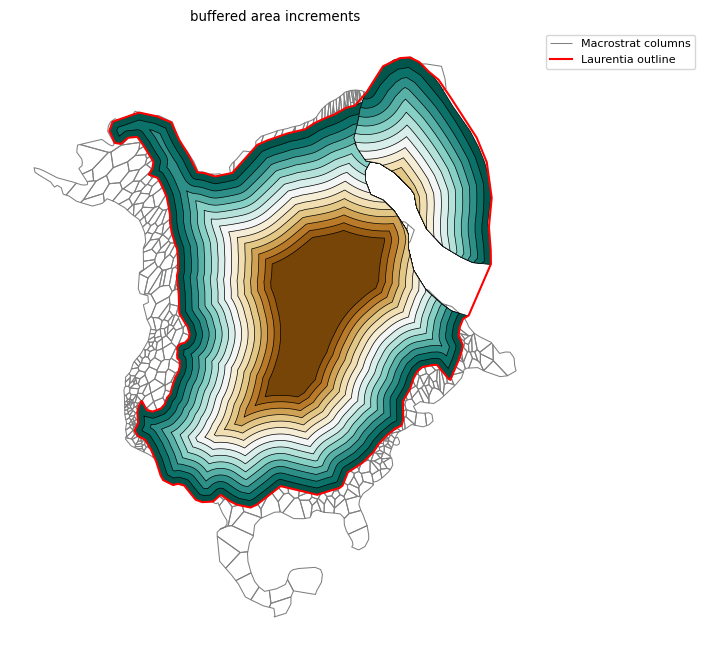

In [25]:
c = plt.get_cmap('Blues')(np.linspace(0, 1, n_interiors))
cmap = matplotlib.colormaps['BrBG']


plt.figure(figsize=(8, 8))
ax = plt.axes()
columns.boundary.plot(ax=ax, color='grey', linewidth=0.75, label='Macrostrat columns')

for ii in range(n_interiors-1, 0, -1):
    interiors[ii].plot(ax=ax, color=cmap(ii/n_interiors), zorder=2)
    interiors[ii].boundary.plot(ax=ax, color='k', linewidth=0.5, zorder=2)    
    
ax.plot(laurentia.boundary.values[0].xy[0], laurentia.boundary.values[0].xy[1], color='r', label='Laurentia outline')

plt.title('buffered area increments')
plt.legend(bbox_to_anchor=(1, 1))

ax.axis('off')

# plt.savefig('figures/buffer_visualization.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Example visualizations

Example sediment presence map.

In [ ]:
columns_cord = gpd.read_file('gis/USGS_cordilleran_columns_wgs.shp').to_crs(proj4)
cord_cols = columns_cord[['col_id', 'geometry']]
tmp = seds_by_column_and_age_range(units_seds, columns, 100, 90, method='presence')

In [ ]:
cmap = cm.get_cmap('gray_r', 10)
ax = tmp.plot(column='presence', cmap=ListedColormap(cmap([3, 7])), figsize=(3,3))
plt.plot(*cord_cols.unary_union.convex_hull.exterior.xy, color='k', linewidth=1.5)
ax.axis('off')
ax.set_title('marine sediments, 90-100 Ma', fontsize=15)
# plt.savefig('figures/sed_presence_example.pdf', format='pdf', bbox_inches='tight')
plt.show()

Time series example.

In [ ]:
wib = np.zeros(nt)
for jj in trange(nt, leave=False):
        t1 = t_edges[jj]
        t2 = t_edges[jj+1]
        df = seds_by_column_and_age_range(units_seds, columns.loc[columns['col_id'].isin(cord_cols['col_id'])], t1, t2, method='presence')
        # make into area fraction
        wib[jj] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/ \
                                    columns.loc[ring_columns[ii].index]['col_area'].astype(float).sum()

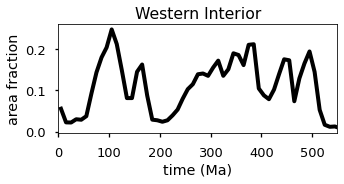

In [36]:
plt.figure(figsize=(5,2))

plt.plot(t, wib, color='k', linewidth=4)

plt.xlabel('time (Ma)')
plt.ylabel('area fraction')
plt.title('Western Interior')

plt.xlim([0, 550])

# plt.savefig('figures/timeseries_example.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Sealevel and Proxy Records

Let's also load sealevel datasets to compare with the resulting curve. 

In [26]:
haq = pd.read_excel('data/Haq2005.xlsx')
miller2020 = pd.read_excel('data/Miller2020.xlsx')
miller = pd.read_excel('data/Globalsealevelrecords_miller.xls')
marcilly = pd.read_excel('data/Marcilly2022.xlsx', sheet_name='Land - flooding - sea levels', header=[0, 1])
marcilly.sort_values(('Age ', '(Ma)'), inplace=True)
marcilly_supp = pd.read_excel('data/Marcilly2022.xlsx', sheet_name='Binned curves used for comparis', header=[0, 1])
marcilly_supp.sort_values(('Age ', 'Ma'), inplace=True)

Also, let's smooth the sealevel curve somewhat to focus on the long-term trends.

In [27]:
from scipy.signal import butter, filtfilt

def smooth_eustasy(t, sl):
    """
    function for smoothing eustatic curves.
    t: time in Ma
    sl: sea level 
    
    returns smoothed sealevel curves with consistent time axis
    """
    
    # first it is necessary to impose even sampling
    t_int = np.arange(0, 601, 1)
    sl_int = np.interp(t_int, t, sl, left=np.nan, right=np.nan)
    
    # filter with zero-phase backward-forward lowpass butterworth filter
    # choose bandpass to match sampling interval in macrostrat data
    wn = np.abs(1/dt)/(1/2/np.mean(np.diff(t_int)))
    b, a = butter(4, wn, btype='lowpass')
    sl_smooth = np.empty(len(t_int))
    sl_smooth[:] = np.nan
    sl_smooth[~np.isnan(sl_int)] = filtfilt(b, a, sl_int[~np.isnan(sl_int)])
    
    return sl_smooth, t_int

In [28]:
cols = ['Haq and Al-Qahtani (2005)',
        'Miller et al. (2005)',
        'Kominz et al. (2008)',
        'Miller et al. (2020)',
        'Marcilly et al. (2022)',
        'van der Meer et al. (2017)',
        'Kocsis and Scotese (2020)',
        'Vérard et al. (2015)']

sl_data = pd.DataFrame(data=np.vstack([smooth_eustasy(haq['Age (Ma)'], 
                                           haq['sea level (m)'])[0],
                                       smooth_eustasy(miller['Age (GTS12; Ma)\nsea level estimated  (Miller et al., 2005)'], 
                                           miller['Sea level (m) backstripped w/ estimated lowstand  (Miller et al., 2005)'])[0],
                                       smooth_eustasy(miller['Age (GTS12; Ma)\nsea level estimated  (Kominz et al., 2008)'],
                                           miller['Sea level (m) backstripped w/ estimated lowstand  (Kominz et al., 2008)'])[0],
                                       smooth_eustasy(miller2020['Age (MA)'], miller2020['Sea level (m)'])[0], 
                                       smooth_eustasy(marcilly[('Age ', '(Ma)')], 
                                                      marcilly[('Modern land sea level (C = 176.6 106km2/km)', 'm')])[0],
                                       smooth_eustasy(marcilly_supp[('Age ', 'Ma')], 
                                                      marcilly_supp[('Van der Meer et al. (2017) corrected fro weathering ', 'm')])[0],
                                       smooth_eustasy(marcilly_supp[('Age ', 'Ma')], 
                                                      marcilly_supp[('Kocsis & Scotese (2020) - calculated sea level ', 'm')])[0],
                                       smooth_eustasy(marcilly_supp[('Age ', 'Ma')], 
                                                      marcilly_supp[('Verard (2015)', 'm')])[0]]).T, 
                       columns=cols, index=np.arange(0, 601, 1))

phanerozoic_cols = ['Haq and Al-Qahtani (2005)', 
                    'Marcilly et al. (2022)', 
                    'van der Meer et al. (2017)', 
                    'Kocsis and Scotese (2020)', 
                    'Vérard et al. (2015)'] 

Sanity check plot for the sea level curves.

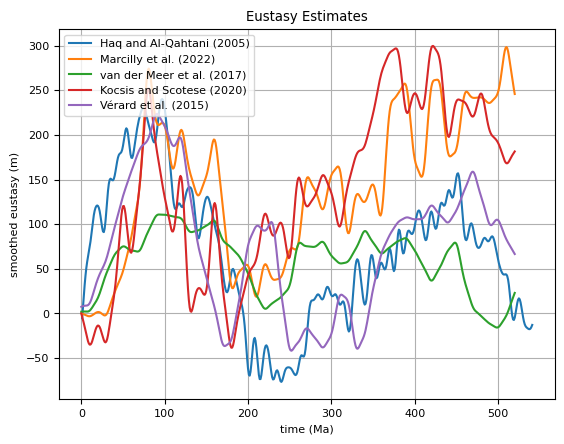

In [29]:
sl_data[phanerozoic_cols].plot()

plt.xlabel('time (Ma)')
plt.ylabel('smoothed eustasy (m)')
plt.title('Eustasy Estimates')

plt.grid()

plt.show()

Rohde and Muller (2005) present a fossil diversity curve for the Phanerozoic, which we can also load below.

In [31]:
fossil = pd.read_excel('data/RohdeMuller2005_fossil-diversity.xlsx', sheet_name='Data versus Time', skiprows=48)

Seawater Sr data for the Phanerozoic are available from Veizer et al. (1999).

In [32]:
sr = pd.read_excel('data/Veizer1999.xls', sheet_name='Ottawa-Bochum Data', skiprows=7, skipfooter=13)
sr_lit = pd.read_excel('data/Veizer1999_lit.xls', sheet_name='Literature Data', skiprows=8, skipfooter=698)

# combine
sr = pd.concat([sr, sr_lit], ignore_index=True, axis=0)

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sr_smooth = lowess(sr['87Sr/86Sr'], sr['Age (Ma)'], frac=0.015)

sr_dt = np.mean(np.diff(sr_smooth[:, 0]))

# use same time axis as everything else
sr_smooth_int = np.interp(t, sr_smooth[:, 0], sr_smooth[:, 1],  right=np.nan, left=np.nan)

# drop nans
idx = ~np.isnan(sr_smooth_int)
sr_smooth_int = sr_smooth_int[idx]
t_sr = t[idx]

Sanity check plot.

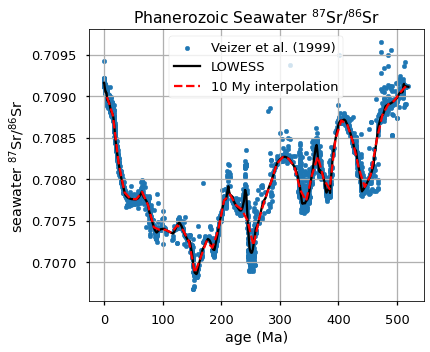

In [33]:
plt.figure(figsize=(6,5))

plt.scatter(sr['Age (Ma)'], sr['87Sr/86Sr'], marker='.', label='Veizer et al. (1999)')
plt.plot(sr_smooth[:, 0], sr_smooth[:, 1], 'k-', label='LOWESS')
plt.plot(t_sr, sr_smooth_int, 'r--', label='10 My interpolation')

plt.xlabel('age (Ma)')
plt.ylabel('seawater $^{87}$Sr/$^{86}$Sr')
plt.title('Phanerozoic Seawater $^{87}$Sr/$^{86}$Sr')
plt.legend()

plt.grid()
plt.show()

Compute and plot a spectrum for the resampled, smoothed Sr data. This computation requires the [spectral](https://github.com/sarttiso/spectral) module.

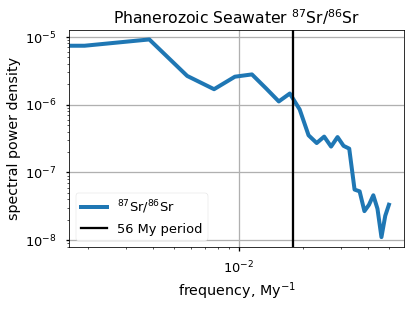

In [34]:
S_sr, f_sr = multitaper(signal.detrend(sr_smooth_int), 10, nw=2)

plt.figure(figsize=(6,4))

plt.loglog(f_sr, S_sr, linewidth=4, label='$^{87}$Sr/$^{86}$Sr')
plt.axvline(0.018, color='k', label='56 My period')

plt.xlabel('frequency, My$^{-1}$')
plt.ylabel('spectral power density')
plt.title('Phanerozoic Seawater $^{87}$Sr/$^{86}$Sr')
plt.legend()

plt.grid()
plt.show()

## Fractional Sediment Coverage Visualization

With this figure, I hope to distinguish the M-curve first order eustatic signal tied to the super-continent cycle and ocean basin formation from the higher frequency variability that can be tied to sedimentation in specific and well-known basins on North America.

In [30]:
def overlap(start1, end1, start2, end2):
    """how much does the range (start1, end1) overlap with (start2, end2)"""
    return max(max((end2-start1), 0) - max((end2-end1), 0) - max((start2-start1), 0), 0)

In [31]:
import cartopy.crs as ccrs
import sys
# sys.path.insert(1, r'C:\Users\adrian\Documents\python\pygplates')
sys.path.insert(1, r'pygplates_0.36.0_py310_win64/pygplates/')
import pygplates
# import shapefile

# sf = shapefile.Reader('gplates/ceed/
ceed_poly_path = 'gplates/ceed/CEED6_LAND.shp'
comp_subduct_path = 'gplates/compressional_subduction.gpml'
# subduct_path = 'gplates/subduction.gpml'
rot_path = 'gplates/ceed/Torsvik_Cocks_HybridRotationFile.rot'

comp_subduct_df = gpd.read_file('gplates/compressional_subduction/compressional_subduction.shp')
comp_subduct_df = comp_subduct_df.to_crs(proj4)

In [32]:
def plot_timeslice(t1, t2, axis_coords, axis_width, arrow_coords, name, p=None, fig=plt.gcf()):
    """
    function for plotting a timeslice like those shown in the "map within time windows section" above.
    """
    df = seds_by_column_and_age_range(units_seds, columns, t1, t2, method='presence')
    
    # generate axis position in figure coordinates
    axis_position = np.append(fig.transFigure.inverted().transform(ax_main.transData.transform(axis_coords)), np.array([axis_width, axis_width]))
    
    # plot
    ax = plt.axes()
    ax.set_position(axis_position)
    # df.plot(column='presence', cmap=ListedColormap(cmap([3, 7])), ax=ax)
    df.plot(column='presence', cmap=ListedColormap(['#aaaaaa', '#443eff']), ax=ax)
    columns.boundary.plot(ax=ax, color='k', linewidth=0.05)
    laurentia.boundary.plot(ax=ax, color='k')
    
    # get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # sutures to plot
    # sut_idx = np.zeros(sut.shape[0]).astype(bool)
    # for ii in range(sut.shape[0]):
    #     sut_idx[ii] = overlap(t2, t1, sut.iloc[ii]['EXMIN'], sut.iloc[ii]['EXMAX']) > 0
    # sut.loc[sut_idx].plot(color='r', ax=ax)
    
    # plot subduction
    idx = (comp_subduct_df['TOAGE']<t1) & (comp_subduct_df['FROMAGE']>t2) # overlap temporally
    comp_subduct_df[idx].plot(ax=ax, color='r')
    
    # reset limits
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    
    # I forget what this does...
    tmp_pos = ax.get_position()
    axis_position[2] = tmp_pos.width
    ax.set_position(axis_position)
    tmp_pos = ax.get_position()
    
    # draw arrow
    base_x0y0 = ax_main.transData.inverted().transform(fig.transFigure.transform((tmp_pos.x0, tmp_pos.y0)))
    base_x1y1 = ax_main.transData.inverted().transform(fig.transFigure.transform((tmp_pos.x1, tmp_pos.y1)))
    base_coords = (base_x1y1 - base_x0y0)/2 + axis_coords
    dx = arrow_coords[0] - base_coords[0]
    dy = arrow_coords[1] - base_coords[1]
    ax_main.arrow(base_coords[0], base_coords[1], dx, dy, width=0.002, color='k')
    
    # format
    if p is None:
        ax.set_title(f'{name}\n{int(t1):d}-{int(t2):d} Ma', 
                     backgroundcolor='w', bbox=dict(edgecolor='k', facecolor='w'), fontsize=7)
    else:
        ax.set_title(f'{name}\np={p:1.2f}\n{int(t1):d}-{int(t2):d} Ma', 
                     backgroundcolor='w', bbox=dict(edgecolor='k', facecolor='w'), fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

<Figure size 640x480 with 0 Axes>

In [33]:
def plot_paleogeo(t, axis_coords, axis_width, arrow_coords, name, fig=plt.gcf()):
    """
    plot a paleogeography at a specified time
    """
    # ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0))
    
    # generate axis position in figure coordinates
    axis_position = np.append(fig.transFigure.inverted().transform(ax_main.transData.transform(axis_coords)), np.array([axis_width, axis_width]))
    
    # plot
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.set_position(axis_position)
    
    reconstruction = 'gplates/scratch/tmp.shp'
    reconstruction_comp_sub = 'gplates/scratch/tmp2.shp'
    # reconstruction_sub = 'gplates/scratch/tmp3.shp'
    # reconstruction_comp_sub = 'gplates/subduction.gpml'
    pygplates.reconstruct(ceed_poly_path, rot_path, reconstruction, t, 0)
    pygplates.reconstruct(comp_subduct_path, rot_path, reconstruction_comp_sub, t, 0)
    # pygplates.reconstruct(subduct_path, rot_path, reconstruction_sub, t, 0)
    
    # for some reason, reconstructed geometries output into a list do not plot well as polygons. easier to just write to and read from shapefiles
    # geometries = []
    # for shape in reconstruction:
    #     latlon = shape.get_reconstructed_geometry().to_lat_lon_array()
    #     polygon = Polygon([(lat, lon) for lon, lat in latlon])
    #     geometries.append(polygon)
        
    # paleo_geo = gpd.GeoDataFrame(geometry=geometries, crs='epsg:4326')
    
    paleo_geo = gpd.read_file(reconstruction)
    paleo_comp_subduct = gpd.read_file(reconstruction_comp_sub)
    
    paleo_geo = paleo_geo.to_crs('esri:54009')
    paleo_comp_subduct = paleo_comp_subduct.to_crs('esri:54009')
    
    paleo_geo.plot(ax=ax, edgecolor='k', linewidth=1, facecolor='gray')
    paleo_comp_subduct.plot(ax=ax, color='r')
    
    # try:
    #     paleo_subduct = gpd.read_file(reconstruction_sub)
    # except:
    #     pass
    # else:
    #     paleo_subduct = paleo_subduct.to_crs('esri:54030')
    #     paleo_subduct.plot(ax=ax, color='orange')
    
    # ax.set_axis_off()
    ax.set_title('%s, %d Ma' % (name, t), fontsize=8)
    ax.set_extent((-179, 179, -90, 90))
        
    # return ax

<Figure size 640x480 with 0 Axes>

In [34]:
def plot_tectonics(name, t1, t2, type_, margin_):
    # heights for plotting of events
    if margin_ == 'West':
        y1 = 0
        y2 = 1
    elif margin_ == 'South':
        y1 = 1
        y2 = 2
    elif margin_ == 'East':
        y1 = 2
        y2 = 3
    elif margin_ == 'North':
        y1 = 3
        y2 = 4
        
    # colors for event types
    if type_ == 'Orogen':
        c = 'Reds'
    elif type_ == 'Subduction':
        c = 'Blues'
    
    # set up mesh for plotting gradient
    

Define each of the 8 sequences.

In [35]:
sequences = pd.read_excel('data/sequences.xlsx')
sequences.replace(np.nan, None, inplace=True)
paleogeo_snaps = pd.read_excel('data/paleogeographic_snapshots.xlsx')
orogens = pd.read_excel('data/tectonics.xlsx', sheet_name='orogens')
subduct = pd.read_excel('data/tectonics.xlsx', sheet_name='subduction zones')

In [36]:
# plotting params
time_slice_wid = 0.22

In [37]:
peak_t_idx = np.in1d(t, sequences['Peak'])
interior_idx = 6

Flooding from interior outwards.

This cell computes the ratios of the flooded areas of the interiors and the total flooded area. To be clear, `interior_sed_frac` is the ratio of the flooded area to the total area of each buffered increment expanding outwards from the interior of the continent:
$$
\frac{f_i}{A_i}
$$
where $f_i$ is the flooded area for the $i$th interior slice, and $A_i$ is the area of that interior slice.

The computation below evaluates the ratio
$$
\frac{f_i}{f_{\text{tot}}}
$$
where as before $f_i$ is the flooded area of the $i$th interior slice, and $f_{\text{tot}}$ is the total flooded area for that particular time window.

In [42]:
flooded_area = interior_sed_frac[:, -1] * interior_columns[-1]['col_area'].astype(float).sum()
frac_interior = np.zeros(interior_sed_frac.shape)
for ii in range(n_interiors):
    frac_interior[:, ii] = (interior_sed_frac[:, ii] * interior_columns[ii]['col_area'].astype(float).sum()) / flooded_area

# one way of many to show the "gradient" in area fractional flooding with buffer distance
interior_sed_frac_diff = (interior_sed_frac[:, np.arange(2, n_interiors)] - interior_sed_frac[:, np.arange(0, n_interiors-2)])/interior_sed_frac[:, -1].reshape(-1, 1)

sequence_peak_idx = np.array([np.argwhere(x == t).squeeze() for x in sequences['Peak'].values])

In [39]:
from matplotlib.patches import Patch, Rectangle
import matplotlib as mpl
mpl.rcParams['path.simplify'] = False

In [40]:
# strong continental subduction peaks
sequence_style_1 = {'facecolor':'#ADD8E6', 'edgecolor':'k', 'width':20}

# sauk
sequence_style_2 = {'facecolor':'#708090', 'edgecolor':'k', 'width':20}

# weak peaks
sequence_style_3 = {'facecolor':'lightgrey', 'edgecolor':'k', 'width':10}

sequence_style_lookup = {'Sauk': sequence_style_2, 'Tippecanoe': sequence_style_1, 'Kaskaskia I': sequence_style_1,
                         'Kaskaskia II': sequence_style_3, 'Absaroka I': sequence_style_3, 'Absaroka II & III': sequence_style_3, 
                         'Zuni I': sequence_style_1, 'Zuni II':sequence_style_1}

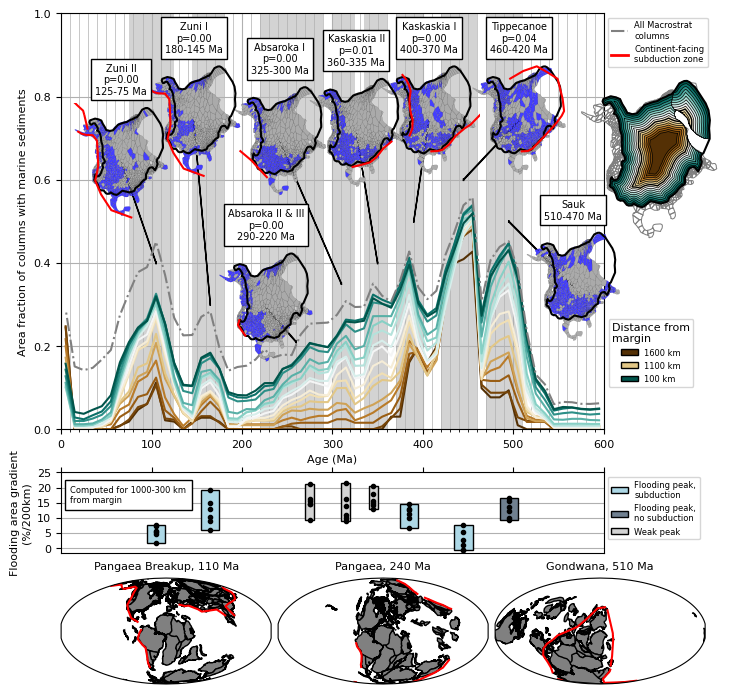

In [44]:
fig = plt.figure(figsize=(7, 5.4))

# gs = GridSpec(2, 3, height_ratios=[3,1], figure=fig)

ax_main = plt.axes()
# ax_main = fig.add_subplot(gs[:, :])

# make plots for varying widths of Laurentian margin
cmap = matplotlib.colormaps['BrBG']
    
# labels
l = []
lab = []

# in outwards
# for ii in range(2, n_interiors):
#     l.append(ax_main.plot(t, interior_sed_frac[:, ii], color=cmap(ii/n_interiors), zorder=ii)[0])
#     lab.append('%d km' % (buffer_widths[-ii]))
# no legend
for ii in range(n_interiors):
    ax_main.plot(t, interior_sed_frac[:, ii], color=cmap(ii/n_interiors), zorder=ii+3)
    
# also plot difference in marginal and interior flooding areas
# l.append(ax_main.plot(t[peak_t_idx], 
#          interior_sed_frac[peak_t_idx][:, -1]-interior_sed_frac[peak_t_idx][:, interior_idx], 
#          'ks', zorder=100)[0])
# lab.append('margin - interior\nfractional flooding')

# plot fraction of interior vs total flooded area at some distance from margin
# l.append(ax_main.plot(t, frac_interior[:, interior_idx], 
#          'k--', linewidth=1, zorder=100)[0])
# lab.append('Interior/total flooding')

# l.append(ax_main.plot(t, interior_sed_frac[:, -1]-interior_sed_frac[:, int_idx], 'k-'))
# lab.append('margin - interior fractional flooding')
    
# also plot "null hypothesis" of all columns
l.append(ax_main.plot(t, all_sed_frac, color='grey', linestyle='-.', zorder=20)[0])
lab.append('All Macrostrat\ncolumns')

# create legend entry for arcs
from matplotlib.lines import Line2D
l.append(Line2D([0], [0], color='r', linewidth=2))
lab.append('Continent-facing\nsubduction zone')

ax_main.set_axisbelow(True)
ax_main.set_ylabel('Area fraction of columns with marine sediments')
ax_main.set_xlabel('Age (Ma)')
ax_main.patch.set_visible(False)
ax_main.xaxis.set_minor_locator(MultipleLocator(10))
ax_main.grid(which='major', zorder=0)
ax_main.grid(which='minor', linewidth=0.5, zorder=0)
ax_main.set_ylim([0, 1])
ax_main.set_xlim([0, 600])
leg = ax_main.legend(l, lab, loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=6)

# plot time slices
for ii in range(sequences.shape[0]):
    cur_t1 = sequences.iloc[ii]['Begin']
    cur_t2 = sequences.iloc[ii]['End']
    cur_coords = [sequences.iloc[ii]['Figure Left'], 
               sequences.iloc[ii]['Figure Bottom']]
    cur_arrow = [sequences.iloc[ii]['Arrow X'],
                 sequences.iloc[ii]['Arrow Y']]
    cur_name = sequences.iloc[ii]['Name']
    cur_p = sequences.iloc[ii]['p-value']
    plot_timeslice(cur_t1, cur_t2, cur_coords, time_slice_wid, cur_arrow, cur_name, p=cur_p, fig=fig)
    ax_main.add_patch(patches.Rectangle((cur_t2, 0), cur_t1-cur_t2, 1, zorder=0, facecolor='lightgray'))
    
    
# plot legend for interpreting buffered margin increments
ax_leg = plt.axes((0.8, 0.45, 0.33, 0.32))
columns.boundary.plot(ax=ax_leg, color='grey', linewidth=0.75, label='Macrostrat columns')

for ii in range(n_interiors-1, -1, -1):
    if ii == interior_idx:
        interiors[ii].plot(ax=ax_leg, color=cmap(ii/n_interiors), zorder=2)
        interiors[ii].boundary.plot(ax=ax_leg, color='k', linewidth=1, zorder=2)  
    else:
        interiors[ii].plot(ax=ax_leg, color=cmap(ii/n_interiors), zorder=2)
        interiors[ii].boundary.plot(ax=ax_leg, color='k', linewidth=0.5, zorder=2)    

ax_leg.plot(laurentia.boundary.values[0].xy[0], laurentia.boundary.values[0].xy[1], color='k', label='Laurentia outline')
ax_leg.axis('off')

# add actual legend with a couple lines for interpreting the buffered distances
buffers4legend = [0, interior_idx-1, 15]
leg_elem = [Patch(facecolor=cmap(ii/n_interiors), edgecolor='k') for ii in buffers4legend]
leg_labels = [f'{buffer_widths[-x-1]} km' for x in buffers4legend]
ax_leg.legend(leg_elem, leg_labels, 
              loc='upper left', bbox_to_anchor=[0.2, -0.4],
              title='Distance from\nmargin', fontsize=6)


# plot flooding increment ranges in axis below area flooding sequences
idx_slice = slice(6, 12)
flood_grad_dists = np.array([np.flip(buffer_widths)[np.arange(2, n_interiors)], np.flip(buffer_widths)[np.arange(0, n_interiors-2)]]).T[idx_slice]
# set up position for new axis
ax_main_bounds = ax_main.get_position().bounds
ax_incs_pos = [ax_main_bounds[0], -0.12, ax_main_bounds[2], 0.15]
ax_incs = plt.axes(ax_incs_pos)
for ii in range(len(sequences)):
    cur_seq_name = sequences.iloc[ii]['Name']
    cur_peak = sequences.iloc[ii]['Peak']
    cur_diffs = 100*interior_sed_frac_diff[sequence_peak_idx[ii], idx_slice]
    # plot points
    ax_incs.plot([cur_peak]*len(cur_diffs), cur_diffs, 'k.', zorder=5)

    # plot box
    cur_rect = Rectangle((cur_peak-sequence_style_lookup[cur_seq_name]['width']/2, np.min(cur_diffs)), 
                         sequence_style_lookup[cur_seq_name]['width'], 
                         np.ptp(cur_diffs), 
                         zorder=1, 
                         facecolor=sequence_style_lookup[cur_seq_name]['facecolor'],
                         edgecolor=sequence_style_lookup[cur_seq_name]['edgecolor'])
    ax_incs.add_patch(cur_rect)
# ax_incs.boxplot(interior_sed_frac_diff[sequence_peak_idx].T*100, positions=sequences['Peak'],
#         flierprops=dict(marker='.', markerfacecolor='k'),
#        widths=10,
#        showfliers=True)
ax_incs.set_xlim([0, 600])
ax_incs.grid(axis='y')
ax_incs.set_ylabel('Flooding area gradient\n(%/200km)')
ax_incs.set_xticks([0, 100, 200, 300, 400, 500, 600])
ax_incs.set_xticklabels([])
ax_incs.set_yticks([0, 5, 10, 15, 20, 25])
ax_incs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# text explaining domain of computation
ax_incs.text(10, 15, f'Computed for {flood_grad_dists[0, 1]}-{flood_grad_dists[-1, 0]} km\nfrom margin', 
             fontsize=6, bbox={'edgecolor': 'k', 'facecolor':'w'})
ax_incs.set_axisbelow(True)
# legend for gradient plots
leg_elem = [Patch(facecolor=sequence_style_1['facecolor'], edgecolor=sequence_style_1['edgecolor']),
            Patch(facecolor=sequence_style_2['facecolor'], edgecolor=sequence_style_2['edgecolor']),
            Patch(facecolor=sequence_style_3['facecolor'], edgecolor=sequence_style_3['edgecolor'])]
leg_labels = ['Flooding peak,\nsubduction', 'Flooding peak,\nno subduction', 'Weak peak']
ax_incs.legend(leg_elem, leg_labels, loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=6)


# plot paleogeographic snapshots
for ii, paleosnap in paleogeo_snaps.iterrows():
    cur_t = paleosnap['Age']
    cur_coords = [paleosnap['Figure Left'], 
               paleosnap['Figure Bottom']]
    cur_arrow = [paleosnap['Arrow X'],
                 paleosnap['Arrow Y']]
    cur_name = paleosnap['Name']
    plot_paleogeo(cur_t, cur_coords, 0.3, cur_arrow, cur_name, fig=fig)

# ax_main.set_title('Marine sedimentary coverage')

# plt.savefig('figures/area_flooding_Phanerozoic_v7_vanilla.png', format='png', dpi=1200, bbox_inches='tight')
# plt.savefig('figures/area_flooding_Phanerozoic_v5.tiff', format='tiff', dpi=1200, bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
# plt.savefig('figures/area_flooding_Phanerozoic_v6.eps', format='eps', dpi=1200, bbox_inches='tight')
# plt.savefig('figures/area_flooding_Phanerozoic_v7.pdf', format='pdf', dpi=1200, bbox_inches='tight')

plt.show()

,t_age,b_age,environ_y
unit_id,,,
4552,4.0333,13.2725,marine marine
4553,26.6225,62.7000,inferred marine marine
4554,83.6000,115.1000,marine marine
4559,142.4000,145.0000,marine marine
4557,170.9000,204.9500,platform/shelf-margin reef carbonate marine
4558,204.9500,208.5000,inferred marine marine


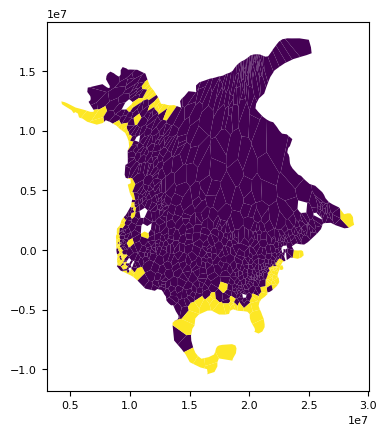

In [42]:
quat = seds_by_column_and_age_range(units_seds, columns, 8, 0, method='presence')
quat.plot(column='presence')
idx = quat['presence'] == 1
quat_marine_cols = quat[idx].index
idx = units_seds['col_id'] == quat_marine_cols[0]

units_seds[idx][['t_age', 'b_age', 'environ_y']]

Flooding from margin inwards.

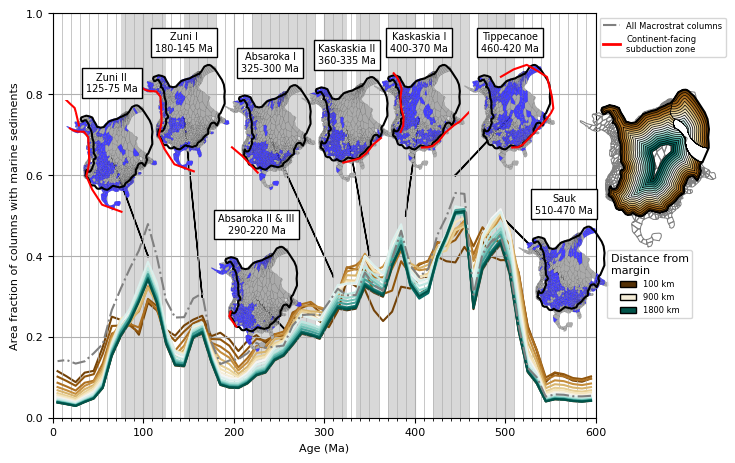

In [44]:
fig = plt.figure(figsize=(7, 5.25))

# gs = GridSpec(2, 3, height_ratios=[3,1], figure=fig)

ax_main = plt.axes()
# ax_main = fig.add_subplot(gs[:, :])

# make plots for varying widths of Laurentian margin
cmap = matplotlib.colormaps['BrBG']
    
# labels
l = []
lab = []

for ii in range(0, n_rings):
    ax_main.plot(t, margin_sed_frac[:, ii], color=cmap(ii/n_rings), zorder=ii)
    

# also plot "null hypothesis" of all columns
l.append(ax_main.plot(t, all_sed_frac, color='grey', linestyle='-.', zorder=20)[0])
lab.append('All Macrostrat columns')

# create legend entry for arcs
from matplotlib.lines import Line2D
l.append(Line2D([0], [0], color='r', linewidth=2))
lab.append('Continent-facing\nsubduction zone')

ax_main.set_ylabel('Area fraction of columns with marine sediments')
ax_main.set_xlabel('Age (Ma)')
ax_main.patch.set_visible(False)
ax_main.xaxis.set_minor_locator(MultipleLocator(10))
ax_main.grid(which='major')
ax_main.grid(which='minor', linewidth=0.5)
ax_main.set_ylim([0, 1])
ax_main.set_xlim([0, 600])
leg = ax_main.legend(l, lab, loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=6)

# plot time slices
for ii in range(sequences.shape[0]):
    cur_t1 = sequences.iloc[ii]['Begin']
    cur_t2 = sequences.iloc[ii]['End']
    cur_coords = [sequences.iloc[ii]['Figure Left'], 
               sequences.iloc[ii]['Figure Bottom']]
    cur_arrow = [sequences.iloc[ii]['Arrow X'],
                 sequences.iloc[ii]['Arrow Y']]
    cur_name = sequences.iloc[ii]['Name']
    plot_timeslice(cur_t1, cur_t2, cur_coords, time_slice_wid, cur_arrow, cur_name, fig=fig)
    ax_main.add_patch(patches.Rectangle((cur_t2, 0), cur_t1-cur_t2, 1, zorder=0, facecolor='gray', alpha=0.3))
    
    
# plot legend for interpreting buffered margin increments
ax_leg = plt.axes((0.8, 0.42, 0.35, 0.33))
columns.boundary.plot(ax=ax_leg, color='grey', linewidth=0.75, label='Macrostrat columns')

for ii in range(n_rings-1, 0, -1):
    rings[ii].plot(ax=ax_leg, color=cmap(ii/n_rings), zorder=2)
    rings[ii].boundary.plot(ax=ax_leg, color='k', linewidth=0.5, zorder=2)    
        
ax_leg.plot(laurentia.boundary.values[0].xy[0], laurentia.boundary.values[0].xy[1], color='k', label='Laurentia outline')

ax_leg.axis('off')

# add actual legend with a couple lines for interpreting the buffered distances
buffers4legend = [0, 8, 17]
ring_widths = np.arange(0, 18)*100 + 100
leg_elem = [Patch(facecolor=cmap(ii/n_rings), edgecolor='k') for ii in buffers4legend]
leg_labels = [f'{ring_widths[x]} km' for x in buffers4legend]
ax_leg.legend(leg_elem, leg_labels, 
              loc='upper left', bbox_to_anchor=[0.2, 0.05],
              title='Distance from\nmargin', fontsize=6)

# plt.savefig('figures/area_flooding_Phanerozoic_inward.png', format='png', dpi=1200, bbox_inches='tight')
# plt.savefig('figures/area_flooding_Phanerozoic_inward.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Interior fraction of flooded area

This figure shows the fraction of interior versus total flooded area (basically, what fraction of the flooded area is in the interior for each buffered area).

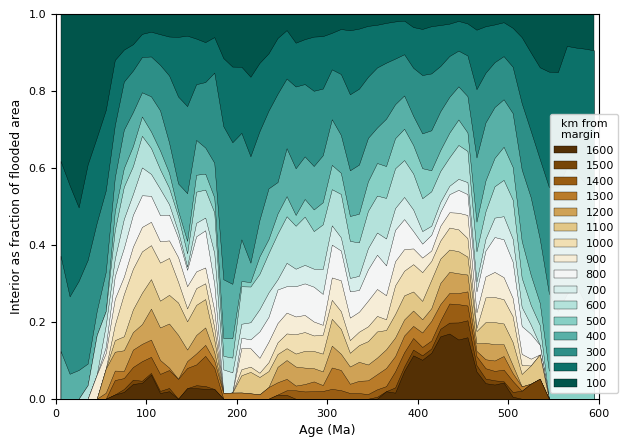

In [43]:
fig = plt.figure(figsize=(7, 5))
ax = plt.axes()

leg_patches = []
leg_labels = []
for ii in range(n_interiors):
    ax.fill_between(t, frac_interior[:, ii], 
                    color=cmap(ii/n_interiors), 
                    edgecolor='k',
                    linewidth=0.25,
                    zorder=n_interiors-ii)   
    leg_patches.append(Patch(facecolor=cmap(ii/n_interiors),
                             edgecolor='k',
                             linewidth=0.25))
    leg_labels.append(buffer_widths[-ii-1])
    
ax.set_xlim([0, 600])
ax.set_ylim([0, 1])
ax.set_xlabel('Age (Ma)', fontsize=9)
ax.set_ylabel('Interior as fraction of flooded area', fontsize=9)

ax.legend(leg_patches, leg_labels, title='km from\nmargin', 
          loc='lower left',
          bbox_to_anchor=[0.9, 0], 
          framealpha=0.9)

# plt.savefig('figures/interior-flooded-fraction.pdf', format='pdf', dpi=1200, bbox_inches='tight')

### Other interior fraction visualizations

In [ ]:
sequence_peak_idx = np.array([np.argwhere(x == t).squeeze() for x in sequences['Peak'].values])

Differences considered:
[[1300 1500]
 [1200 1400]
 [1100 1300]
 [1000 1200]
 [ 900 1100]
 [ 800 1000]
 [ 700  900]
 [ 600  800]
 [ 500  700]
 [ 400  600]
 [ 300  500]
 [ 200  400]
 [ 100  300]]


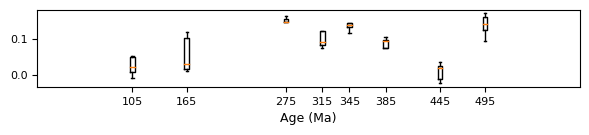

In [277]:
# interior_sed_frac_diff = interior_sed_frac[:, -1].reshape(-1, 1) - interior_sed_frac
# interior_sed_frac_diff = interior_sed_frac[:, np.arange(2, n_interiors)] - interior_sed_frac[:, np.arange(0, n_interiors-2)]
interior_sed_frac_diff = (interior_sed_frac[:, np.arange(2, n_interiors)] - interior_sed_frac[:, np.arange(0, n_interiors-2)])/interior_sed_frac[:, -1].reshape(-1, 1)
# interior_sed_frac_diff = interior_sed_frac[:, np.arange(0, n_interiors-2)]/interior_sed_frac[:, np.arange(2, n_interiors)]
# interior_sed_frac_diff = frac_interior[:, np.arange(3, n_interiors)]-frac_interior[:, np.arange(0, n_interiors-3)]
# interior_sed_frac_diff = frac_interior[:, np.arange(3, n_interiors)]-frac_interior[:, np.arange(0, n_interiors-3)]

fig = plt.figure(figsize=(7, 1))
ax = plt.axes()

leg_patches = []
leg_labels = []
# for ii in range(0, n_interiors-2):
#     ax.plot(t, interior_sed_frac_diff[:, ii], 
#                     color=cmap(ii/(n_interiors-2)) )
    # ax.fill_betweenp(t, interior_sed_frac_diff[:, ii], 
    #                 color=cmap(ii/(n_interiors-1)), 
    #                 edgecolor='k',
    #                 linewidth=0.25,
    #                 zorder=n_interiors-ii)   
    # leg_patches.append(Patch(facecolor=cmap(ii/n_interiors),
    #                          edgecolor='k',
    #                          linewidth=0.25))
    # leg_labels.append(buffer_widths[-ii-1])

# plot sequences
wid = 10
idx_slice = slice(1, 15)
# for ii in range(len(sequences)):
#     # ax.axvline(sequences.iloc[ii]['Peak'], color='k')
#     cur_peak = sequences.iloc[ii]['Peak']
#     cur_diffs = interior_sed_frac_diff[sequence_peak_idx[ii], idx_slice]
#     # plot points
#     ax.plot([cur_peak]*len(cur_diffs), cur_diffs, 'k.', zorder=5)

#     # plot box
#     cur_rect = Rectangle((cur_peak-wid/2, np.min(cur_diffs)), wid, np.ptp(cur_diffs), zorder=1, 
#                          facecolor='lightgrey',
#                          edgecolor='k')
#     ax.add_patch(cur_rect)
    
ax.boxplot(interior_sed_frac_diff[sequence_peak_idx, 6:11].T, positions=sequences['Peak'], 
           widths=5,
           showfliers=False)
    
ax.set_xlim([0, 600])
# ax.set_ylim([0, 1])
ax.set_xlabel('Age (Ma)', fontsize=9)
# ax.set_ylabel('Interior as fraction of flooded area', fontsize=9)

# ax.legend(leg_patches, leg_labels, title='km from\nmargin', 
#           loc='lower left',
#           bbox_to_anchor=[0.9, 0], 
#           framealpha=0.9)

print(f'Differences considered:\n{np.array([np.flip(buffer_widths)[np.arange(2, n_interiors)], np.flip(buffer_widths)[np.arange(0, n_interiors-2)]]).T[idx_slice]}')

In [ ]:
interior_sed_frac_diff = (interior_sed_frac[:, np.arange(2, n_interiors)] - interior_sed_frac[:, np.arange(0, n_interiors-2)])/interior_sed_frac[:, -1].reshape(-1, 1)

fig = plt.figure(figsize=(7, 5))
ax = plt.axes()

# plot sequences
wid = 10
idx_slice = slice(7, 12)
for ii in range(len(sequences)):
    cur_peak = sequences.iloc[ii]['Peak']
    cur_diffs = interior_sed_frac_diff[sequence_peak_idx[ii], idx_slice]
    # plot points
    ax.plot([cur_peak]*len(cur_diffs), cur_diffs, 'k.', zorder=5)

    # plot box
    cur_rect = Rectangle((cur_peak-wid/2, np.min(cur_diffs)), wid, np.ptp(cur_diffs), zorder=1, 
                         facecolor='lightgrey',
                         edgecolor='k')
    ax.add_patch(cur_rect)
    
ax.set_xlim([0, 600])
ax.set_xlabel('Age (Ma)', fontsize=9)

print(f'Differences considered:\n{np.array([np.flip(buffer_widths)[np.arange(2, n_interiors)], np.flip(buffer_widths)[np.arange(0, n_interiors-2)]]).T[idx_slice]}')

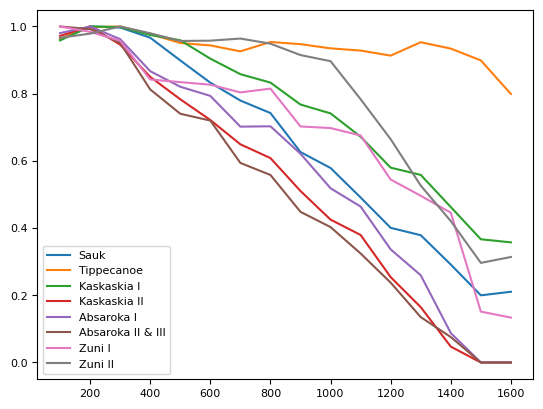

In [68]:
fig = plt.figure()
ax = plt.axes()

for ii in range(len(sequences)):
    ax.plot(np.flip(buffer_widths), interior_sed_frac[sequence_peak_idx[ii]]/np.max(interior_sed_frac[sequence_peak_idx[ii]]), label=sequences.iloc[ii]['Name'])

ax.legend()

## Peak Spatial Significance

The basis for the test would be a cost function that penalizes distance of a column with sediments from a margin, and it would need to be normalized for the total number of such columns (or their area?). 

$$
\zeta = \frac{\sum_{i=1}^N A_i\,\vert c_i - m_{\perp_i}\vert}{d_{max}\,\sum_{i=1}^N A_i}
$$

This quantity is at maximum equal to one, and it is larger for  distributions of columns that are close to $d_{max}$, which is the maximum distance across North America. The quantity is minimally zero.  The other terms are 
- $c_i$ : the centroid of a column with marine sediments
- $m_{\perp_i}$ : the projected location of the centroid along the margin (the nearest point)
- $A_i$ : the area of the $i$th column
- $d_{max}$ : the maximum distance across North America (margin to margin)

This formulation permits at least two types of tests for evaluating the significance of an observed flooding distribution:
1. Consider just randomly distributed flooding (possibly with the same-ish total area of flooding? the area normalization should account for different total flooded areas?). Monte Carlo a distribution of $\zeta$ for "random" flooding, and then see where the observed $\hat{\zeta}$ falls within that Monte Carlo distribution. The quantile would be the p-value. In this test, the defined margin would be held constant, i.e., the inferred subduction zone would not change, and the test would be simply against a null hypothesis of random flooding.
2. Consider holding the flooded area the same and instead moving the margin that is considered. Holding the margin length the same, how does $\zeta$ change with the moving margin, and how does $\hat{\zeta}$ compare to the distribution of $\zeta$ for all the movements of the margin? In this test, the idea is basically to just determine how close the subduction zone is to the (optimal) value of $\zeta$ that is minimized over all margin configurations of equal length. 

Method 2 is pretty complicated since it requires being able to create a moving window (or multiple moving windows) of the margin perimeter, which would need to account for Greenland's rifting.

- Tippecanoe
- Kaskaskia I
- Kaskaskia II
- Absaroka I
- Zuni I
- Zuni II

In [45]:
from pygeodesy import sphericalTrigonometry as st
from shapely.geometry import Point
import shapely
import random

Might have to play around with the projection, but here's something at least.

In [46]:
laurentia_columns_wgs = laurentia_columns.to_crs(wgs84)
comp_subduct_wgs = comp_subduct_df.to_crs(wgs84)

Precompute the Laurentia column centroids as `pygeodesy.LatLon`'s.  

In [47]:
centroid_latlon = []
for ii, column in laurentia_columns_wgs.iterrows():
    cur_lonlat = np.array(column.geometry.centroid.xy).squeeze()
    centroid_latlon.append(st.LatLon(cur_lonlat[1], cur_lonlat[0]))

laurentia_columns_wgs['centroid latlon'] = centroid_latlon

laurentia_columns_wgs['col_area'] = laurentia_columns_wgs['col_area'].astype(float)

# array with areas and centroids for MC below
laurentia_for_mc = laurentia_columns_wgs[['col_area', 'centroid latlon']].values
n_cols_laurentia = laurentia_for_mc.shape[0]

In [48]:
def cost(centroids, areas, lines, dmax):
    """
    centroids: coordinates of column centroids as LatLons
    areas: areas of columns to consider (same length as centroids)
    lines: list of list of latlons
    """
    n_centroids = len(centroids)
    
    # get distances from lines
    n_lines = len(lines)
    distances = np.zeros((n_centroids, n_lines))
    for ii in range(n_lines):
        # compute distances of centroids to current line
        nearest_on_lines = [st.nearestOn3(centroid, lines[ii], limit=None) for centroid in centroids]
                                   
        # compute nearest distance
        distances[:, ii] = np.array([nearest[1] for nearest in nearest_on_lines])
    
    # take minimum distances
    distances = np.min(distances, axis=1)
    
    # compute cost
    return np.sum(areas*distances)/(np.sum(areas)*dmax)

In [49]:
sequence_rows = ['Tippecanoe',
                 'Kaskaskia I', 
                 'Kaskaskia II',
                 'Absaroka I',
                 'Absaroka II & III',
                 'Zuni I',
                 'Zuni II']

n_seq = len(sequence_rows)

# strong flooding peaks
sequences_active = sequences[sequences['Name'].isin(sequence_rows)]

dmax = 6.5e6

### Method 1

In [50]:
costs = np.zeros(n_seq)
n_mc = 1000
costs_mc = np.zeros((n_mc, n_seq))

for ii in tqdm(range(n_seq)):
    cur_t1 = sequences_active.iloc[ii]['Begin']
    cur_t2 = sequences_active.iloc[ii]['End']
    
    df_flooded = df_flooded = seds_by_column_and_age_range(units_seds, laurentia_columns_wgs, 
                                                           cur_t1, cur_t2, method='presence')
    idx = df_flooded['presence'] == 1
    n_flooded = np.sum(idx)
    areas = laurentia_columns_wgs.loc[idx]['col_area'].astype(float).values.tolist()
    centroids = laurentia_columns_wgs.loc[idx]['centroid latlon'].values.tolist()
    
    # get subduction zone(s)
    idx = (comp_subduct_wgs['TOAGE']<cur_t1) & (comp_subduct_wgs['FROMAGE']>cur_t2) # overlap temporally
    lines_geom = comp_subduct_wgs[idx].geometry.values
    lines = []
    for jj in range(len(lines_geom)):
        # deal with multilinestrings
        if type(lines_geom[jj]) is shapely.geometry.multilinestring.MultiLineString:
            for line in list(lines_geom[jj].geoms):
                lines.append(np.array(line.xy).T)
        else:
            lines.append(np.array(lines_geom[jj].xy).T)
    lines = [[st.LatLon(lat, lon) for lon, lat in line] for line in lines]
    
    # cost for observed flooding
    costs[ii] = cost(centroids, areas, lines, dmax)
    
    # monte carlo flooding cost
    
    for jj in tqdm(range(n_mc)):
        # random flooding
        cur_idx = random.sample(range(700), n_flooded)
        costs_mc[jj, ii] = cost(laurentia_for_mc[cur_idx, 1], laurentia_for_mc[cur_idx, 0], lines, dmax)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
np.savetxt(f'data/costs_mc_sequences_2023-06_{dmax:1.1e}.csv', costs_mc, delimiter=',')

Load Monte Carlo'd $\zeta$ if alrady computed.

In [133]:
costs_mc = np.loadtxt('data/costs_mc_sequences_2023-06_6.5e+06.csv', delimiter=',')

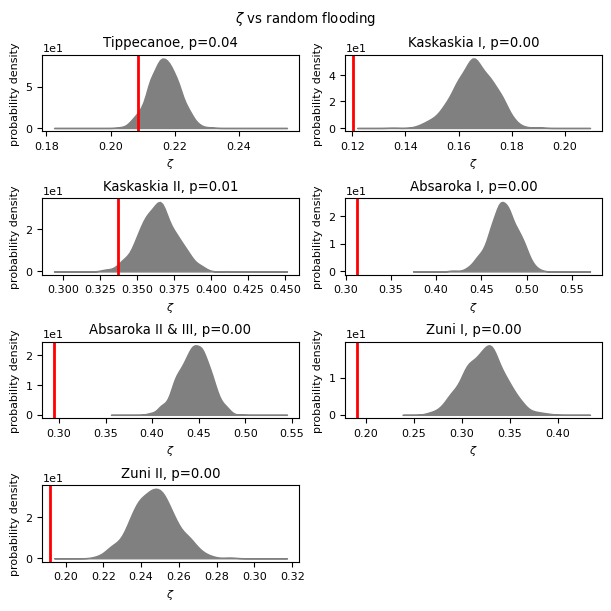

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(6,6), layout='constrained')

for ii, sequence in enumerate(sequence_rows):
    ax_idx = np.unravel_index(ii, ax.shape)
    # p value
    cur_p = 1-np.sum(costs[ii] < costs_mc[:, ii])/n_mc
    
    # plotting zeta coordinates
    max_zeta = np.max(costs_mc[:, ii])
    min_zeta = np.min(costs_mc[:, ii])
    range_zeta = max_zeta - np.min([min_zeta, costs[ii]])
    zeta_fact = 0.1
    cur_zeta = np.linspace((1-zeta_fact)*min_zeta, max_zeta*(1+zeta_fact), 100)
    
    # fit kde
    cur_kde = stats.gaussian_kde(costs_mc[:, ii])
    # _ = ax[ax_idx].hist(costs_mc[:, ii], bins=int(np.sqrt(n_mc)), density=True)
    
    # actually plot
    ax[ax_idx].fill_between(cur_zeta, cur_kde(cur_zeta), color='gray', linestyle='-')
    ax[ax_idx].axvline(costs[ii], color='r', linewidth=2)
    ax[ax_idx].set_title(f'{sequence}, p={cur_p:1.2f}')
    ax[ax_idx].set_xlabel('$\zeta$')
    ax[ax_idx].set_ylabel('probability density')
    ax[ax_idx].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
plt.suptitle('$\zeta$ vs random flooding')

ax[3,1].axis('off')

plt.savefig('figures/zeta_stats.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figures/zeta_stats.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

### Method 2

In [60]:
from osgeo import ogr
from shapely.wkt import loads

In [61]:
laurentia_wgs = laurentia.to_crs(wgs84)

In [62]:
# densify laurentia boundary
laurentia_wkt = laurentia_wgs.geometry.values[0].wkt
laurentia_ogr = ogr.CreateGeometryFromWkt(laurentia_wkt)
laurentia_ogr.Segmentize(0.2) # largest spacing...
laurentia_dense = loads(laurentia_ogr.ExportToWkt())

# make into latlon
laurentia_dense_lon, laurentia_dense_lat = laurentia_dense.exterior.coords.xy
laurentia_dense_latlon = [st.LatLon(lat, lon) for lon, lat in zip(laurentia_dense_lon, laurentia_dense_lat)]
n_pt_perim = len(laurentia_dense_latlon)

# compute distances between subsequent points along perimeter
perim_dist = np.zeros(n_pt_perim)
for ii in range(n_pt_perim):
    pt1 = laurentia_dense_latlon[ii]
    pt2 = laurentia_dense_latlon[np.mod(ii+1, n_pt_perim)]
    perim_dist[ii] = st.perimeterOf([pt1, pt2])

In [63]:
def wrapped_idx(start, stop, n): 
    # fn to convert your start stop to a wrapped range
    if stop<=start:
        stop += n
    return np.arange(start, stop)%n

In [64]:
# number of rotations
n_rot = 100
perim_inc = st.perimeterOf(laurentia_dense_latlon)/n_rot

Given a desired number of rotations, we will find the indices into `perim_dist` (and thereby `laurentia_dense_latlon`) that give consecutive "lumps" of `perim_dist` such that the distances in each lump sum roughly to the perimeter of Laurentia divided by the number of rotations.

We'll recompute costs to reflect distance from the margin, not distances from subduction zone, since this approach will just be considering the margin of Laurentia.

In [65]:
def closest_idx(pt, pts):
    n = len(pts)
    dists = np.zeros(n)
    for jj in range(n):
        dists[jj] = st.perimeterOf([pt, pts[jj]])
    return np.argmin(dists)

def upper_idx(start_idx, total_length):
    """
    upper index for desired cumulative length and starting index, computed clockwise
    """
    cur_length = 0
    up_idx = np.mod(start_idx+1, n_pt_perim)
    while cur_length < total_length:
        idx = wrapped_idx(start_idx, up_idx, n_pt_perim)
        cur_length = np.sum(perim_dist[idx])
        up_idx += 1
    return np.mod(up_idx, n_pt_perim)

In [66]:
costs = np.zeros(n_seq)
costs_rot = np.zeros((n_rot, n_seq))

for ii in tqdm(range(n_seq)):

    cur_t1 = sequences_active.iloc[ii]['Begin']
    cur_t2 = sequences_active.iloc[ii]['End']

    df_flooded = df_flooded = seds_by_column_and_age_range(units_seds, laurentia_columns_wgs, 
                                                           cur_t1, cur_t2, method='presence')
    idx = df_flooded['presence'] == 1
    n_flooded = np.sum(idx)
    areas = laurentia_columns_wgs.loc[idx]['col_area'].astype(float).values.tolist()
    centroids = laurentia_columns_wgs.loc[idx]['centroid latlon'].values.tolist()

    # figure out projection of subduction zone onto margin of laurentia

    # get subduction zone(s)
    idx_sub = (comp_subduct_wgs['TOAGE']<cur_t1) & (comp_subduct_wgs['FROMAGE']>cur_t2) # overlap temporally
    lines_geom = comp_subduct_wgs[idx_sub].geometry.values
    lines = []
    for jj in range(len(lines_geom)):
        # deal with multilinestrings
        if type(lines_geom[jj]) is shapely.geometry.multilinestring.MultiLineString:
            for line in list(lines_geom[jj].geoms):
                lines.append(np.array(line.xy).T)
        else:
            lines.append(np.array(lines_geom[jj].xy).T)
    lines = [[st.LatLon(lat, lon) for lon, lat in line] for line in lines]

    n_lines = len(lines)

    # project onto margin
    lines_on_margin = []
    cum_dist = []
    for jj in range(n_lines):
        nearest_on_margin = [st.nearestOn3(point, laurentia_dense_latlon, limit=None, closed=True) for point in lines[jj]]

        # keep only points that are close enough (lets say 300 km)
        distances = np.array([nearest[1] for nearest in nearest_on_margin])
        idx = distances < 500e3
        if np.sum(idx) < 2: # need at least two points
            continue
        else:  
            idx = np.argwhere(idx).squeeze()
            # extract points on margin
            lines_on_margin.append([nearest_on_margin[idx[x]][0] for x in range(len(idx))])

            # cumulative distance along margin of the projected lines
            cum_dist.append(st.perimeterOf(lines_on_margin[-1]))

    # figure out the margin trace of the lines_on_margin, since that's what we want to work with. 
    # specifically, we want to the start index into perim_dist (laurentia_dense_latlon) and the total length
    start_idxs = [] # n_lines
    wins = []
    cum_dist_on_margin = [] # cumulative distance on margin (will be longer)
    for jj, line in enumerate(lines_on_margin):
        # figure out if clockwise or not (if not, make clockwise)
        # find closest laurentia_dense_latlon (clunky af)
        first_idx = closest_idx(line[0], laurentia_dense_latlon)
        second_idx = closest_idx(line[1], laurentia_dense_latlon)
        # clockwise
        if first_idx < second_idx:
            start_idxs.append(first_idx)
        # counter clockwise
        else:
            # flip line coordinates
            lines_on_margin[jj].reverse()
            start_idxs.append(closest_idx(lines_on_margin[jj][0], laurentia_dense_latlon))

        # compute distance on margin of first window
        last_idx = closest_idx(lines_on_margin[jj][-1], laurentia_dense_latlon)
        cum_dist_on_margin.append(np.sum(perim_dist[wrapped_idx(start_idxs[jj], 
                                                                last_idx, 
                                                                n_pt_perim)]))

        # create first margin window
        cur_win_idx = wrapped_idx(start_idxs[jj], last_idx, n_pt_perim)
        cur_win = [laurentia_dense_latlon[idx] for idx in cur_win_idx]
        
        # sparsify
        cur_win_sparse = [cur_win[x] for x in range(0, len(cur_win), 3)]
        wins.append(cur_win_sparse)

    margin_wins = [wins] # n_rot

    # compute cost for distance from margin, not subduction zone
    costs[ii] = cost(centroids, areas, wins, dmax)

    # now loop as many times as desired, rotating the total length of the projection around the margin of laurentia
    # output will be moving window of margin points of length n_rot, each entry in margin_wins is a set of lines for cost()
    for jj in tqdm(range(n_rot-1)):
        cur_wins = []
        for kk, line in enumerate(margin_wins[jj]):
            # get next start_idx
            start_idxs[kk] = upper_idx(start_idxs[kk], perim_inc)
            last_idx = upper_idx(start_idxs[kk], cum_dist_on_margin[kk])
            # get new window
            cur_win_idx = wrapped_idx(start_idxs[kk], last_idx, n_pt_perim)
            cur_win = [laurentia_dense_latlon[idx] for idx in cur_win_idx]
            
            # sparsify
            cur_win_sparse = [cur_win[x] for x in range(0, len(cur_win), 3)]
            # wins.append(cur_win_sparse)
            cur_wins.append(cur_win_sparse)

        margin_wins.append(cur_wins)

    # finally, compute costs (first one is just costs[ii])
    costs_rot[0, ii] = costs[ii]
    for jj in tqdm(range(1, n_rot)):
        costs_rot[jj, ii] = cost(centroids, areas, margin_wins[jj], dmax)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [67]:
np.savetxt(f'data/costs_rot_2023-06_{dmax:1.1e}.csv', costs_rot, delimiter=',')

In [146]:
costs_rot = np.loadtxt('data/costs_rot_6.5e+06.csv', delimiter=',')

<Axes: >

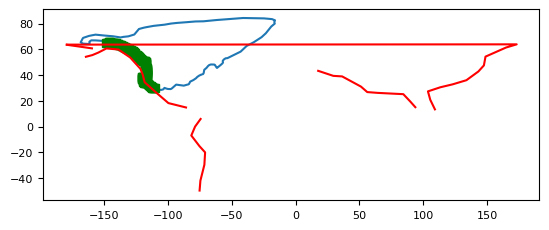

In [68]:
ax = laurentia_wgs.boundary.plot()
for line in lines_on_margin:
    for point in line:
        ax.plot(point.lon, point.lat, 'k.')
ax.plot(lines_on_margin[0][0].lon, lines_on_margin[0][0].lat, 'r.') 
# ax.plot(laurentia_dense_latlon[1876].lon, laurentia_dense_latlon[1876].lat, 'b^')
# ax.plot(laurentia_dense_latlon[135].lon, laurentia_dense_latlon[135].lat, 'b^')
for pt in wins[0]:
    ax.plot(pt.lon, pt.lat, 'gs')
comp_subduct_wgs[idx_sub].plot(ax=ax, color='r')

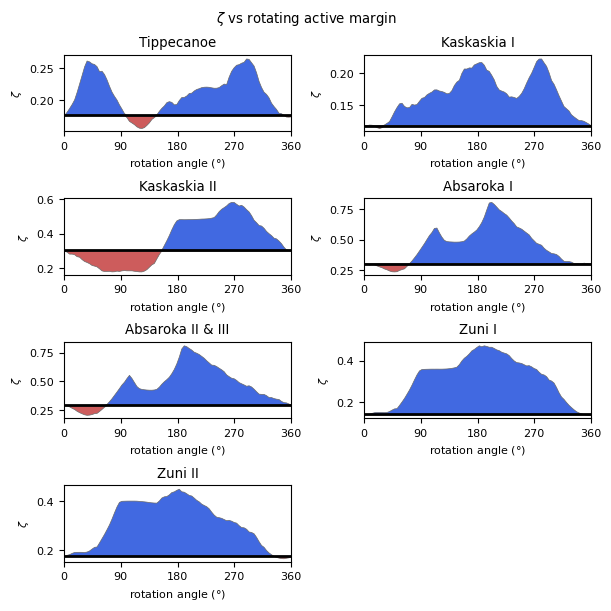

In [70]:
fig, ax = plt.subplots(4, 2, figsize=(6,6), layout='constrained')

# truncation before n_rot reflecting inaccuracy in rotation steps
trunc = 92
# plotting vector, "rotation/moving window angle"
rot_ang = np.linspace(0, 360, trunc)
# truncate rotations to plot
costs_rot_plot = costs_rot[0:trunc, :]

x_ticks = [0, 90, 180, 270, 360]

for ii, sequence in enumerate(sequence_rows):
    ax_idx = np.unravel_index(ii, ax.shape)
    
    # set up plotting
    # get costs below costs[ii]
    cur_costs_below = np.min(np.stack([np.ones(trunc)*costs[ii], costs_rot_plot[:, ii]], axis=1), axis=1)
    # get costs above costs[ii]
    cur_costs_above = np.max(np.stack([np.ones(trunc)*costs[ii], costs_rot_plot[:, ii]], axis=1), axis=1)
    
    # actually plot
    ax[ax_idx].fill_between(rot_ang, costs[ii]*np.ones(trunc), cur_costs_above, 
                            color='royalblue', linestyle='-', edgecolor='dimgrey', linewidth=0.5)
    ax[ax_idx].fill_between(rot_ang, cur_costs_below, costs[ii]*np.ones(trunc), 
                            color='indianred', linestyle='-', edgecolor='dimgrey', linewidth=0.5)
    ax[ax_idx].axhline(costs[ii], color='k', linewidth=2)
    ax[ax_idx].set_title(f'{sequence}')
    ax[ax_idx].set_xlabel('rotation angle ($\degree$)')
    ax[ax_idx].set_ylabel('$\zeta$')
    ax[ax_idx].set_xlim([0, 360])
    ax[ax_idx].set_xticks(x_ticks)
    # ax[ax_idx].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
plt.suptitle('$\zeta$ vs rotating active margin')

ax[3,1].axis('off')

plt.savefig('figures/zeta_rot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('figures/zeta_rot.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

## Eustasy from area of continental flooding

In this section I use the approach of Rowley (2017) to transform the area of flooding through time into a signal of eustatic variability. This transformation requires many assumptions but ultimately links global area of flooding to a vertical deflection in the oceans and on the continents that preserves Earth's mean radius.

Area of flooding is linked then to something Rowley calls the current height of the paleo-shoreline, which can be transformed to the contemporary height of the paleo-shoreline by subtracting the vertical deflection on the continents associated with the area of flooding.

Rowley provides expressions to perform these mappings in the supplementary material:

$$
\text{PHPS}(m) = 2.419\times 10^{-14}\,A_f^2 - 1.378\times 10^{-5}\,A_f + 1817 \\
\Delta z_{cc}(m) = 2.52\times 10^{-14}\,A_f^2 - 1.58\times 10^{-5}\,A_f + 2.38\times 10^{3}
$$

where $\text{PHPS}(m)$ is the present height of the paleo-shoreline, $A_f$ is the area of flooding in square kilometers, and $\Delta z_{cc}(m)$ is the vertical deflection on the continents (with respect to the modern hypsometry) associated with a certain area of flooding. 

> Rowley, D.B., 2017, Earth’s Constant Mean Elevation: Implication for Long-Term Sea Level Controlled by Oceanic Lithosphere Dynamics in a Pitman World: The Journal of Geology, v. 125, p. 141–153, doi:10.1086/690197.


In [71]:
"""
present height of the paleo-shoreline
"""
def phps(A):
    return 2.419e-14*A**2 - 1.378e-5*A + 1817

"""
vertical deflection on the continents
"""
def zcc(A):
    return 2.52e-14*A**2 - 1.58e-5*A + 2.38e3

Now I can use the fractional area of marine sedimentary coverage on North America through time to infer eustatic variability in this framework. The fundamental assumption here is that North America is representative of the entire world, which would be the case anyway if a true eustatic signal is preserved.

In [72]:
# proportion of margin columns containing marine sediments
flooding_laurentia = np.zeros(nt)
    
for ii in trange(nt, leave=False):
    t1 = t_edges[ii]
    t2 = t_edges[ii+1]
    df = seds_by_column_and_age_range(units_seds, laurentia_columns, t1, t2, method='presence')
    # area of flooding
    flooding_laurentia[ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()

  0%|          | 0/60 [00:00<?, ?it/s]

Let's compute the same but on the basis of the relative flooding from all Macrostrat columns.

In [73]:
# proportion of margin columns containing marine sediments
flooding_all = np.zeros(nt)
    
for ii in trange(nt, leave=False):
    t1 = t_edges[ii]
    t2 = t_edges[ii+1]
    df = seds_by_column_and_age_range(units_seds, columns, t1, t2, method='presence')
    # area of flooding
    flooding_all[ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()

  0%|          | 0/60 [00:00<?, ?it/s]

Earth's surface area is around 510 million km$^2$. 

Assuming that land constitutes about 150 million km$^2$, we can use the fractional flooding of Laurentia to extrapolate to the world.

The computation is adding the globally extrapolated fraction of land flooding to the oceanic area of 360 million km$^2$.

In [74]:
A = 510e6
f_cont = 0.3
f_ocn = 1-f_cont

"""
extrapolate fractional flooding to global areal flooding and shoreline height
"""
def rowley_eustasy(flood_frac, A=A, f_cont=f_cont, f_ocn=f_ocn):
    flood_area = f_ocn*A + flood_frac * f_cont*A
    sealevel_zpres = phps(flood_area)
    sealevel_z = sealevel_zpres - zcc(flood_area)
    
    return flood_area, sealevel_zpres, sealevel_z

In [75]:
# eustasy estimate from flooding just on Laurentia
flooding_global_Laurentia, sealevel_zpres_Laurentia, sealevel_z_Laurentia = rowley_eustasy(flooding_laurentia/laurentia_area)

# eustatsy estimate from flooding of all Macrostrat
flooding_global_all, sealevel_zpres_all, sealevel_z_all = rowley_eustasy(flooding_all/columns['col_area'].astype(float).sum())

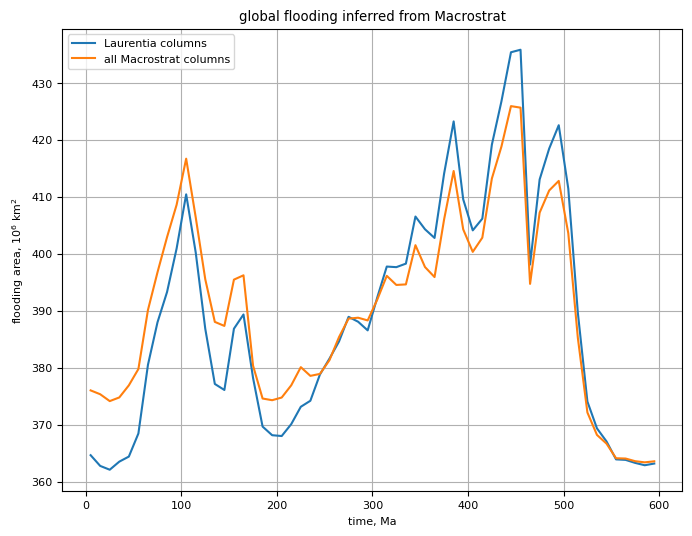

In [101]:
fig = plt.figure(figsize=(8,6))

plt.plot(t, flooding_global_Laurentia/1e6, label='Laurentia columns')
plt.plot(t, flooding_global_all/1e6, label='all Macrostrat columns')


plt.ylabel('flooding area, $10^{6}$ km$^2$')
plt.xlabel('time, Ma')
plt.title('global flooding inferred from Macrostrat')
plt.grid()
plt.legend()

# plt.savefig('figures/flooding_area_no_minustrat.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/flooding_area_no_minustrat.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

Now, let's convert it to sealevel, plot it up and compare with Haq, Miller, Kominz, etc.

Let's also smooth the estimate to basically see how much variance is coming from the M-curve versus the individual flooding peaks.

In [76]:
# set the bandpass threshold to be some (large) amount of millions of years
wn = 1/200
b, a = butter(4, wn, btype='lowpass', fs=np.abs(1/dt))
sealevel_zpres_Laurentia_smooth = np.empty(len(t))
# sl_smooth[:] = np.nan
sealevel_zpres_Laurentia_smooth = filtfilt(b, a, sealevel_zpres_Laurentia)

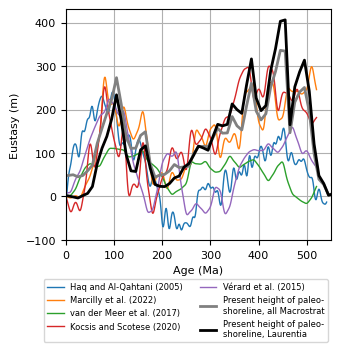

In [78]:
fig = plt.figure(figsize=(3.42, 3))

ax = plt.axes()

# sea level datasets
sl_data[phanerozoic_cols].plot(ax=ax, linewidth=1)

# eustasy inferred from all Macrostrat
ax.plot(t, sealevel_zpres_all, '-', color='grey', label='Present height of paleo-\nshoreline, all Macrostrat', linewidth=2)
# ax.plot(t, sealevel_z_all, '-', color='grey', label='height of paleo-shoreline,\nall Macrostrat', linewidth=3)

# eustasy inferred from Laurentia
ax.plot(t, sealevel_zpres_Laurentia, 'k-', label='Present height of paleo-\nshoreline, Laurentia', linewidth=2)
# ax.plot(t, sealevel_z_Laurentia, 'k-', label='height of paleo-shoreline,\nLaurentia', linewidth=3)

# smoothed eustasy from Laurentia
# ax.plot(t, sealevel_zpres_Laurentia_smooth, 'k--', label='smoothed', linewidth=2)

plt.xlim([0, 550])

plt.ylabel('Eustasy (m)')
plt.xlabel('Age (Ma)')
# plt.title('eustasy extrapolated from Laurentian flooding')
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.legend(bbox_to_anchor=(-0.1, -0.15), loc='upper left', ncols=2, fontsize=6)

# plt.savefig('figures/eustasy_w_minustrat.pdf', format='pdf', dpi=600, bbox_inches='tight')
# plt.savefig('figures/eustasy_w_minustrat.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

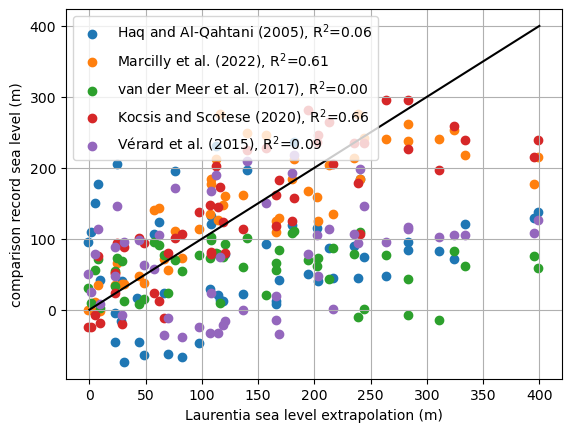

In [189]:
import numpy.ma as ma
idx = np.argsort(t)

for ii in range(len(phanerozoic_cols)):
    cur_x = sealevel_zpres_Laurentia[idx]
    cur_y = np.interp(t[idx], sl_data.index, sl_data[phanerozoic_cols].iloc[:, ii])
    R2 = ma.corrcoef(ma.masked_invalid(cur_x), ma.masked_invalid(cur_y))[0,1]**2
    plt.scatter(cur_x, cur_y, label=f'{phanerozoic_cols[ii]}, R$^2$={R2:1.2f}')
    
plt.plot([0, 400], [0, 400], 'k-')

plt.grid()

plt.xlabel('Laurentia sea level extrapolation (m)')
plt.ylabel('comparison record sea level (m)')
plt.legend()

## Spectral Analysis of Continental Flooding

As noted by Meyers and Peters (2011), the area of sedimentary cover on North America has a timescale of variability of 50-60 My.

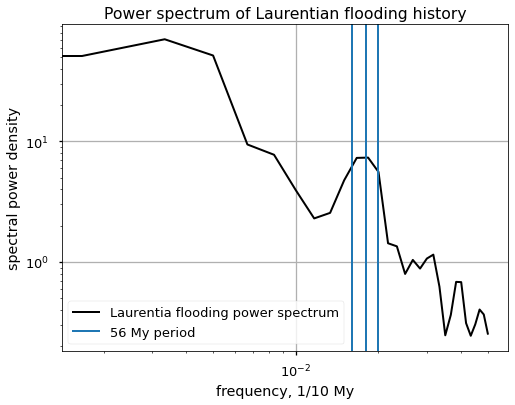

In [57]:
S_est, f = multitaper(signal.detrend(flooding_global_Laurentia)/np.std(flooding_global_Laurentia), 10, nw=2)

plt.figure(figsize=(8,6))
plt.loglog(f, S_est, 'k', linewidth=2, label='Laurentia flooding power spectrum')
plt.axvline(0.018, label='56 My period', linewidth=2)
plt.axvline(0.016, linewidth=2)
plt.axvline(0.02, linewidth=2)

plt.grid()
plt.xlabel('frequency, 1/10 My')
plt.ylabel('spectral power density')
plt.title('Power spectrum of Laurentian flooding history')
plt.legend()

# plt.savefig('figures/flooding_spectrum.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/flooding_spectrum.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

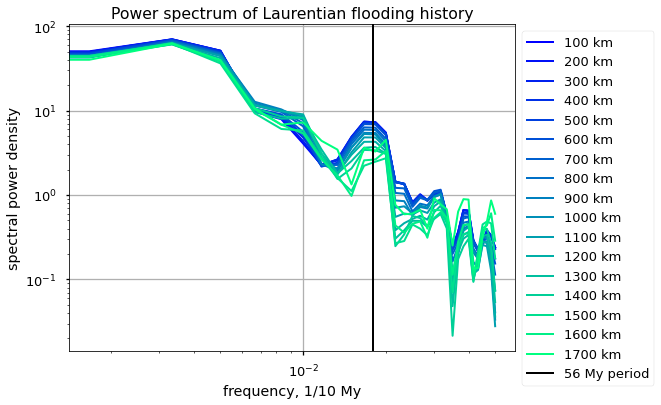

In [58]:
import scipy.signal as signal

plt.figure(figsize=(8,6))

# going inwards
S_est = []
for ii in trange(n_interiors):
    S_est_cur, f = multitaper(signal.detrend(margin_sed_frac[:, ii])/np.std(margin_sed_frac[:, ii]), 10, nw=2)
    S_est.append(S_est_cur)

    plt.loglog(f, S_est_cur, color=cmap(ii), linewidth=2, label='%d km' % buffer_widths[ii])
    
plt.axvline(0.018, label='56 My period', linewidth=2, color='k')
plt.grid()
plt.xlabel('frequency, 1/10 My')
plt.ylabel('spectral power density')
plt.title('Power spectrum of Laurentian flooding history')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# plt.savefig('figures/flooding_spectrum.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/flooding_spectrum.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

Let's compute the spectra progressing inwards from the continental interior.

In [59]:
# laurentia minus the rings
interiors = []
interior_columns = []
n_interior_cols = []

for ii in trange(n_interiors):
    interiors.append(gpd.overlay(laurentia, rings[ii], how='difference'))
    
    # clean up spatial difference
    # take only polygons with sufficient area (others are noise)
    # idx = [jj for jj in range(len(interiors[ii].geometry[0])) if interiors[ii].geometry[0][jj].area > 1000]
    # interiors[ii].geometry[0] = interiors[ii].geometry[0][idx[0]]
    
    interior_columns.append(gpd.sjoin(columns, interiors[ii], predicate='intersects'))
#     interior_columns.append(gpd.sjoin(interiors[ii], columns, op='intersects'))
    n_interior_cols.append(interior_columns[ii].shape[0])
    
interiors.reverse()
interior_columns.reverse()
n_interior_cols.reverse()

  0%|          | 0/17 [00:00<?, ?it/s]

In [60]:
# now compute the sedimentation histories for each interior slice
# proportion of margin columns containing marine sediments
interior_sed_frac = np.zeros((nt, n_interiors))

for ii in trange(n_interiors):
    
    # isolate marine units from these columns
    units_seds_interior = units_seds[units_seds['col_id'].isin(interior_columns[ii].index)]
    
    for jj in trange(nt, leave=False):
        t1 = t_edges[jj]
        t2 = t_edges[jj+1]
        df = seds_by_column_and_age_range(units_seds_interior, columns.loc[interior_columns[ii].index], t1, t2, method='presence')
        # make into area fraction of current ring
#         margin_sed_frac[jj, ii] = df['presence'].sum()/n_ring_cols[ii]
#         margin_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/laurentia_area
        interior_sed_frac[jj, ii] = columns.loc[df[df['presence'] == 1].index, 'col_area'].astype(float).sum()/ \
                                    columns.loc[interior_columns[ii].index]['col_area'].astype(float).sum()

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

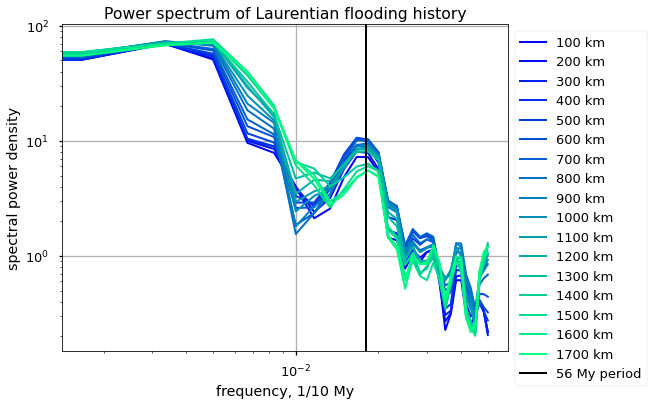

In [61]:
import scipy.signal as signal

plt.figure(figsize=(8,6))

# going inwards
S_est = []
for ii in trange(n_interiors):
    S_est_cur, f = multitaper(signal.detrend(interior_sed_frac[:, ii])/np.std(interior_sed_frac[:, ii]), 10, nw=2)
    S_est.append(S_est_cur)

    plt.loglog(f, S_est_cur, color=cmap(ii), linewidth=2, label='%d km' % buffer_widths[ii])
    
plt.axvline(0.018, label='56 My period', linewidth=2, color='k')
plt.grid()
plt.xlabel('frequency, 1/10 My')
plt.ylabel('spectral power density')
plt.title('Power spectrum of Laurentian flooding history')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# plt.savefig('figures/flooding_spectrum.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/flooding_spectrum.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

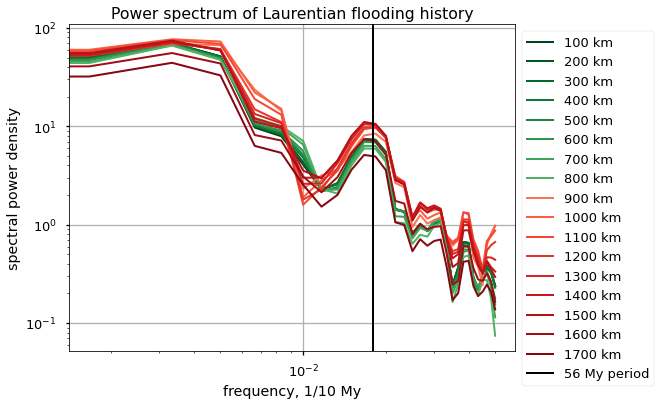

In [62]:
import scipy.signal as signal

plt.figure(figsize=(8,6))

thres = n_interiors-10

# going outwards
S_est = []
for ii in trange(n_rings):
    if ii > thres:
        S_est_cur, f = multitaper(signal.detrend(interior_sed_frac[:, n_rings-ii])/np.std(interior_sed_frac[:, ii]), 10, nw=2)
    else:
        S_est_cur, f = multitaper(signal.detrend(margin_sed_frac[:, ii])/np.std(margin_sed_frac[:, ii]), 10, nw=2)
    
    S_est.append(S_est_cur)
    
    if ii > thres:
        plt.loglog(f, S_est_cur, color=plt.get_cmap('Reds')(ii/n_rings), linewidth=2, label='%d km' % buffer_widths[ii])
    else:
        plt.loglog(f, S_est_cur, color=plt.get_cmap('Greens')(1-ii/n_rings), linewidth=2, label='%d km' % buffer_widths[ii])
    
plt.axvline(0.018, label='56 My period', linewidth=2, color='k')
plt.grid()
plt.xlabel('frequency, 1/10 My')
plt.ylabel('spectral power density')
plt.title('Power spectrum of Laurentian flooding history')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# plt.savefig('figures/flooding_spectrum.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/flooding_spectrum.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

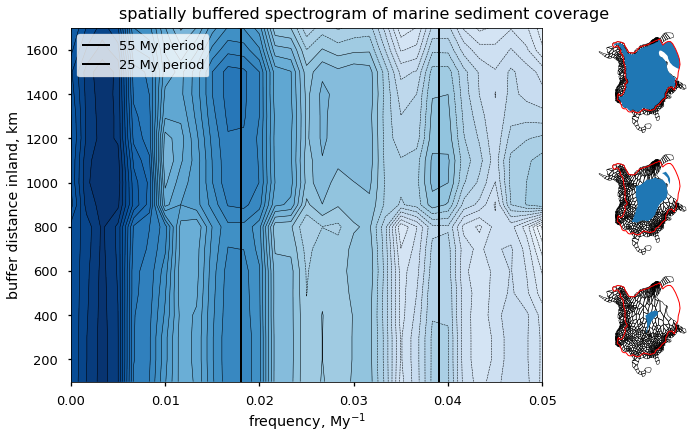

In [63]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)

F, W = np.meshgrid(f, buffer_widths)

gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

ax1 = fig.add_subplot(gs[:, 0])

# Plot the surface
ax1.contourf(F, W, np.log10(np.asarray(S_est)), 30, cmap=plt.cm.Blues)
ax1.contour(F, W, np.log10(np.asarray(S_est)), 30, colors='k', linewidths=0.5)

f1 = 0.018
ax1.axvline(f1, label='%d My period' % (1/f1), linewidth=2, color='k')
f2 = 0.039
ax1.axvline(f2, label='%d My period' % (1/f2), linewidth=2, color='k')


ax1.set_xlabel('frequency, My$^{-1}$')
ax1.set_ylabel('buffer distance inland, km')

ax1.legend()

# plot interior buffer zones
ax2 = fig.add_subplot(gs[0, 1])
columns.boundary.plot(ax=ax2, color='k', linewidth=0.5)
interiors[0].plot(ax=ax2, zorder=10)
laurentia.boundary.plot(ax=ax2, zorder=10, color='r', linewidth=1)
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 1])
columns.boundary.plot(ax=ax3, color='k', linewidth=0.5)
interiors[8].plot(ax=ax3, zorder=10)
laurentia.boundary.plot(ax=ax3, zorder=10, color='r', linewidth=1)
ax3.axis('off')

ax4 = fig.add_subplot(gs[2, 1])
columns.boundary.plot(ax=ax4, color='k', linewidth=0.5)
interiors[16].plot(ax=ax4, zorder=10)
laurentia.boundary.plot(ax=ax4, zorder=10, color='r', linewidth=1)
ax4.axis('off')

fig.suptitle('spatially buffered spectrogram of marine sediment coverage', fontsize=16)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig('figures/56my_buffer_spectrogram.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/56my_buffer_spectrogram.png', format='png', dpi=300, bbox_inches='tight')

plt.show()